In [1]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import scipy.stats as stats
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import json
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Section 1: Public Health Data Analyses

WASTE WATER Data: The below code is the most up-to-date data analysis of waste water analysis in ward island and hunts point. Both recieve wastewater from the bronx, Hunts point is exclusive to the Bronx while wards island recieves some from manhattan.

In [ ]:
WW = pd.read_csv('SARS-CoV-2_concentrations_measured_in_HP_Wastewater.csv')
WW = WW[['Sample Date',"N1 Copies/L"]]
WW["N1 Copies/L"] = WW["N1 Copies/L"].fillna(0)
WW['Sample Date'] = pd.to_datetime(WW['Sample Date'])
WW.set_index('Sample Date', inplace=True)

WW2 = pd.read_csv('SARS-CoV-2_concentrations_measured_in_WI_Wastewater.csv')
WW2 = WW2[['Sample Date',"N1 Copies/L"]]
WW2["N1 Copies/L"] = WW2["N1 Copies/L"].fillna(0)
WW2['Sample Date'] = pd.to_datetime(WW2['Sample Date'])
WW2.set_index('Sample Date', inplace=True)


Clinical Time Series Data:
Below is the same preprocessing steps as above just with NYChealth data of symptoms (confirmed cases,hospitalizations and death counts)

In [96]:
#cases, hospitalizations, deaths, ILI
Bronx_df = pd.read_csv('cases-by-day.csv')
NYC_df = pd.read_csv('cases-by-day-by-borough.csv')
NYC_df.date_of_interest = pd.to_datetime(NYC_df.date_of_interest)
NYC_df.set_index('date_of_interest', inplace=True)
Bronx_df.date_of_interest = pd.to_datetime(Bronx_df.date_of_interest)
ts_case = pd.DataFrame({"ds":Bronx_df.date_of_interest,"y":Bronx_df.BX_CASE_COUNT})
ts_case.set_index('ds', inplace=True)
ts_pcase = pd.DataFrame({"ds":Bronx_df.date_of_interest,"y":Bronx_df.BX_PROBABLE_CASE_COUNT})
ts_pcase.set_index('ds', inplace=True)



Hosp = pd.read_csv('hosp-by-day.csv')
Hosp.date_of_interest = pd.to_datetime(Hosp.date_of_interest)
ts_Hosp = pd.DataFrame({"ds":Hosp.date_of_interest,"y":Hosp.BX_HOSPITALIZED_COUNT})
ts_Hosp.ds= pd.to_datetime(ts_Hosp.ds)
ts_Hosp.set_index('ds', inplace=True)


In [ ]:
#testing rate
tr = pd.read_csv('testrate-by-modzcta.csv')
tr = tr[['week_ending','TESTRATE_BX']]
tr['week_ending'] = pd.to_datetime(tr['week_ending'])
tr.set_index('week_ending', inplace=True)
start_date = '2020-09-01'
mask = (tr.index > start_date)
tr = tr.loc[mask]

tp = pd.read_csv('percentpositive-by-modzcta.csv')
tp = tp[['week_ending','PCTPOS_BX']]
tp['week_ending'] = pd.to_datetime(tp['week_ending'])
tp.set_index('week_ending', inplace=True)
start_date = '2020-09-01'
mask = (tp.index > start_date)
tp = tp.loc[mask]

USA Aggregate Time Series Data:
The Coronavirus Disease 2019 (COVID-19)-Associated Hospitalization Surveillance Network (COVID-NET) hospitalization data are preliminary and subject to change as more data become available. In particular, case counts and rates for recent hospital admissions are subject to lag. Lag for COVID-NET case identification and reporting might increase around holidays or during periods of increased hospital utilization. As data are received each week, prior case counts and rates are updated accordingly. COVID-NET conducts population-based surveillance for laboratory-confirmed COVID-19-associated hospitalizations in children (less than 18 years of age) and adults. COVID-NET covers nearly 100 counties in the 10 Emerging Infections Program (EIP) states (CA, CO, CT, GA, MD, MN, NM, NY, OR, TN) and four Influenza Hospitalization Surveillance Project (IHSP) states (IA [March 2020-May 2022], MI, OH, and UT). Incidence rates (per 100,000 population) are calculated using the National Center for Health Statistics' (NCHS) vintage 2020 bridged-race postcensal population estimates for the counties included in the surveillance catchment area. The rates provided are likely to be underestimated as COVID-19 hospitalizations might be missed due to test availability and provider or facility testing practices. The NCHS bridged-race data used for the denominator for race data provides population data for children ages 0–1 year. To calculate rates of hospitalization among children ages <6 months and 6 months to <12 months, the population for children ages 0–1 year is halved.


In [ ]:
# Load the CSV data into a pandas DataFrame
ts_USA_CDC = pd.read_csv('CDC_COVIDNET.csv')
ts_CDC_subnet = pd.read_csv('CDC-COVID-NET_sub-network.csv')

# Combine 'mmwr year' and 'mmwr week' to create a string representing the date
ts_USA_CDC['date'] = ts_USA_CDC['MMWR-YEAR'].astype(str) + ts_USA_CDC['MMWR-WEEK'].astype(str).str.pad(2, fillchar='0') + '0'
ts_CDC_subnet['date'] = ts_CDC_subnet['MMWR-YEAR'].astype(str) + ts_CDC_subnet['MMWR-WEEK'].astype(str).str.pad(2, fillchar='0') + '0'
# Convert the 'date_string' column to datetime format
ts_USA_CDC['date'] = pd.to_datetime(ts_USA_CDC['date'], format='%Y%W%w')
ts_CDC_subnet['date'] = pd.to_datetime(ts_CDC_subnet['date'], format='%Y%W%w')
ts_USA_CDC = ts_USA_CDC[['date', 'WEEKLY RATE']]
ts_CDC_subnet = ts_CDC_subnet[['date','CATCHMENT', 'WEEKLY RATE']]
ts_USA_CDC.set_index('date', inplace=True)
ts_CDC_subnet.set_index('date', inplace=True)


# Resample the DataFrame to get weekly data per catchment
weekly_series_CDC = ts_CDC_subnet.groupby('CATCHMENT')['WEEKLY RATE'].resample('W').mean().unstack()

# If you want to fill NaN values with 0, you can use the following line
weekly_series_CDC = weekly_series_CDC.fillna(0)

NYS_ts = weekly_series_CDC.T['New York'].to_frame()

weekly_series_CDC_transposed = weekly_series_CDC.T
weekly_series_CDC_transposed.columns


Index(['California', 'Colorado', 'Connecticut', 'Entire Network', 'Georgia',
       'Iowa', 'Maryland', 'Michigan', 'Minnesota', 'New Mexico', 'New York',
       'Ohio', 'Oregon', 'Tennessee', 'Utah'],
      dtype='object', name='CATCHMENT')

In [ ]:
ts_vax_CDC = pd.read_csv('us_state_vaccinations.csv')
ts_vax_CDC['date'] = pd.to_datetime(ts_vax_CDC['date'])
ts_vax_CDC = ts_vax_CDC[["date","location","people_fully_vaccinated_per_hundred"]]
ts_vax_CDC = ts_vax_CDC.pivot(index='date', columns='location', values='people_fully_vaccinated_per_hundred')
ts_vax_CDC['New York'] = ts_vax_CDC['New York State']
print(ts_vax_CDC.columns)


Index(['Alabama', 'Alaska', 'American Samoa', 'Arizona', 'Arkansas',
       'Bureau of Prisons', 'California', 'Colorado', 'Connecticut',
       'Delaware', 'Dept of Defense', 'District of Columbia',
       'Federated States of Micronesia', 'Florida', 'Georgia', 'Guam',
       'Hawaii', 'Idaho', 'Illinois', 'Indian Health Svc', 'Indiana', 'Iowa',
       'Kansas', 'Kentucky', 'Long Term Care', 'Louisiana', 'Maine',
       'Marshall Islands', 'Maryland', 'Massachusetts', 'Michigan',
       'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York State',
       'North Carolina', 'North Dakota', 'Northern Mariana Islands', 'Ohio',
       'Oklahoma', 'Oregon', 'Pennsylvania', 'Puerto Rico',
       'Republic of Palau', 'Rhode Island', 'South Carolina', 'South Dakota',
       'Tennessee', 'Texas', 'United States', 'Utah', 'Vermont',
       'Veterans Health', 'Virgin Islands', 'Virginia', 'Washington',
       'West V

Time series statistics

Measuring the baseline in the following COVID-19 time series data offers several advantages. Firstly, it provides a reference point that represents the typical or average behavior of the disease spread over time. The baseline aids in identifying unusual patterns, outbreak signals, or variations from the norm.

In order to do any statistics we first need to understand the properties of each time-series distribution, this will influence how we model the data/baseline.

We will start with the time series property: stationarity and we will use the Augmented Dickey-Fuller (ADF) Test to determine if we can model a constant baseline.

Principle: The ADF test is used to determine the presence of a unit root in a time series. A unit root implies that a series is non-stationary, meaning it exhibits trends or seasonality that can make it difficult to model and analyze.

Purpose: The ADF test helps in testing the null hypothesis that a unit root exists in the time series. If the test result indicates a rejection of the null hypothesis, it suggests that the series is stationary or can be transformed into a stationary series. Stationary time series exhibit stable statistical properties over time, making them easier to model and analyze.

In [ ]:
from statsmodels.tsa.stattools import adfuller
adft = adfuller(WW, autolag="AIC")
output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used",
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)

adft = adfuller(ts_Hosp, autolag="AIC")
output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used",
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)

adft = adfuller(ts_case,autolag="AIC")
output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used",
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)


       Values                       Metric
0   -5.112802              Test Statistics
1    0.000013                      p-value
2    3.000000             No. of lags used
3  206.000000  Number of observations used
4   -3.462499          critical value (1%)
5   -2.875675          critical value (5%)
6   -2.574304         critical value (10%)
        Values                       Metric
0    -4.177022              Test Statistics
1     0.000720                      p-value
2    19.000000             No. of lags used
3  1045.000000  Number of observations used
4    -3.436623          critical value (1%)
5    -2.864310          critical value (5%)
6    -2.568245         critical value (10%)
        Values                       Metric
0    -4.833250              Test Statistics
1     0.000047                      p-value
2    22.000000             No. of lags used
3  1042.000000  Number of observations used
4    -3.436641          critical value (1%)
5    -2.864318          critical value (

In [ ]:
from statsmodels.tsa.stattools import adfuller
adft = adfuller(ts_USA_CDC,autolag="AIC")
output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used",
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)


       Values                       Metric
0   -3.754337              Test Statistics
1    0.003411                      p-value
2    3.000000             No. of lags used
3  179.000000  Number of observations used
4   -3.467420          critical value (1%)
5   -2.877826          critical value (5%)
6   -2.575452         critical value (10%)


In [ ]:
def adf_test(time_series):
    adft = adfuller(time_series, autolag="AIC")
    return adft

# Apply ADF test to each catchment's time series
results = {}

for index, row in weekly_series_CDC.iterrows():
    catchment = index
    time_series = row.values  # Extract the time series data
    adf_result = adf_test(time_series)
    results[catchment] = adf_result

# Create a DataFrame from the results
output_df = pd.DataFrame(results).T
output_df.columns = ["Test Statistics", "p-value", "No. of lags used", "Number of observations used",
                     "critical value (1%)", "critical value (5%)"]

print(output_df)

               Test Statistics   p-value No. of lags used  \
California           -5.608524  0.000001                1   
Colorado             -3.506852  0.007813                2   
Connecticut          -4.621472  0.000118                2   
Entire Network       -3.652365  0.004835                3   
Georgia              -4.485182  0.000209                3   
Iowa                 -2.186266  0.211268               10   
Maryland             -4.328018  0.000397                4   
Michigan              -3.96312  0.001616                1   
Minnesota            -3.752853  0.003428                1   
New Mexico           -3.462455  0.009005                2   
New York             -3.886365  0.002138                1   
Ohio                 -3.354575  0.012608                2   
Oregon                -4.49541    0.0002                2   
Tennessee            -4.476381  0.000217                3   
Utah                 -3.555523  0.006671                1   

               Number o

# Supplemental file figure 1:
Autocorrelation analysis

cases


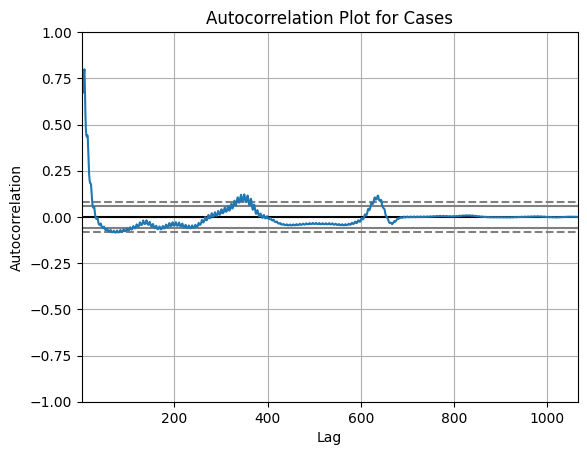

hospitalizations


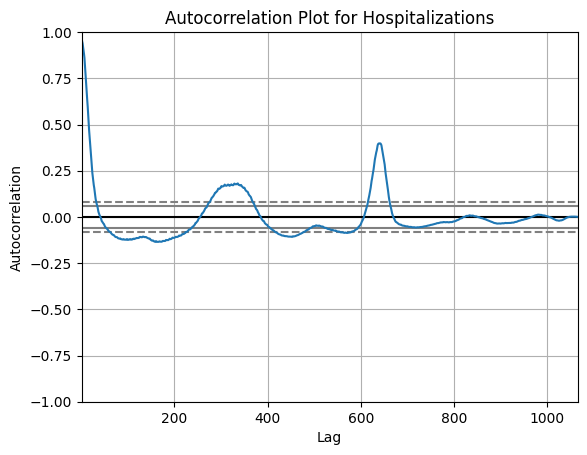

In [ ]:
print('cases')
plt1 = pd.plotting.autocorrelation_plot(ts_case)
plt1.set_title('Autocorrelation Plot for Cases')
plt1.set_xlabel('Lag')
plt1.set_ylabel('Autocorrelation')
plt.show()

# Plot autocorrelation for hospitalizations
print('hospitalizations')
plt2 = pd.plotting.autocorrelation_plot(ts_Hosp)
plt2.set_title('Autocorrelation Plot for Hospitalizations')
plt2.set_xlabel('Lag')
plt2.set_ylabel('Autocorrelation')
plt2.figure.savefig("Auto_correlation_hosp.pdf", format="pdf", bbox_inches="tight")
plt.show()

All time series reject the ADF null hypothesis, this means that we can measure a constant baseline for all time series. To determine if we can use the mean or median value as the baseline we test if we can approximate the time series Y values as normally distributed.

To determine if they can approximate to a normal distribution we use the Shapiro-Wilk Test.

Principle: The Shapiro-Wilk test is a normality test used to assess whether a given sample follows a normal distribution. It is sensitive to both the shape and location of the distribution.

Purpose: The Shapiro-Wilk test helps in examining the assumption of normality for a time series. Normality is often assumed in many statistical methods and models, and violations of this assumption can affect the validity of the results. By conducting the Shapiro-Wilk test, we can determine whether the data can be reasonably approximated by a normal distribution.

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


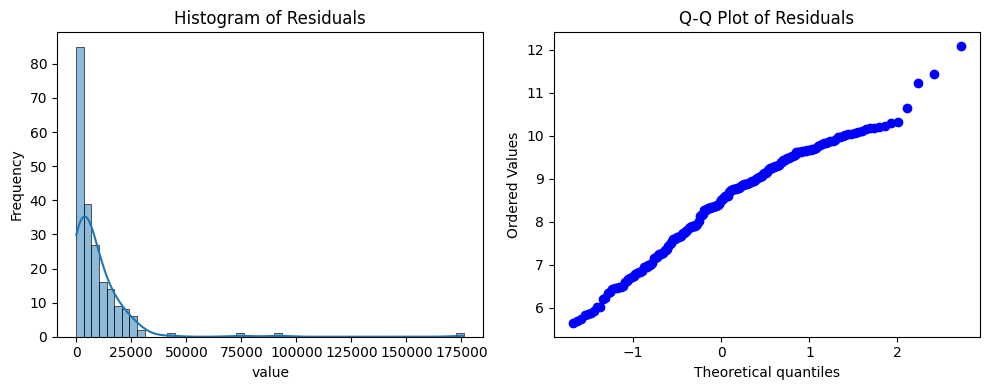

Shapiro-Wilk p-value: 1.0


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


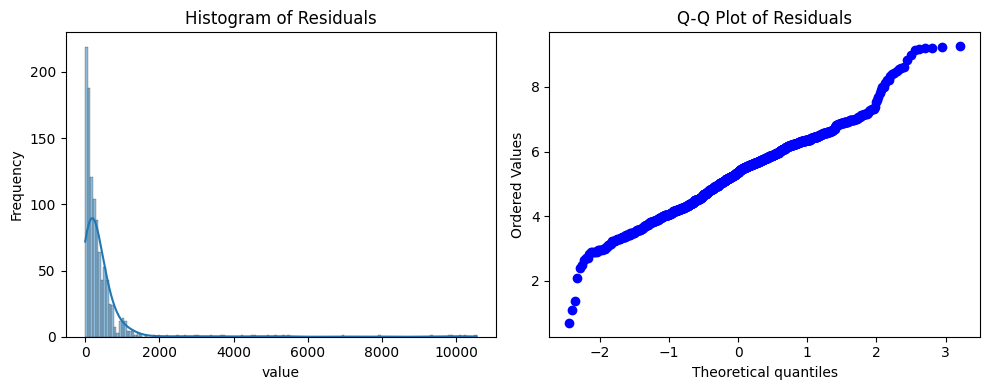

Shapiro-Wilk p-value: 1.0


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


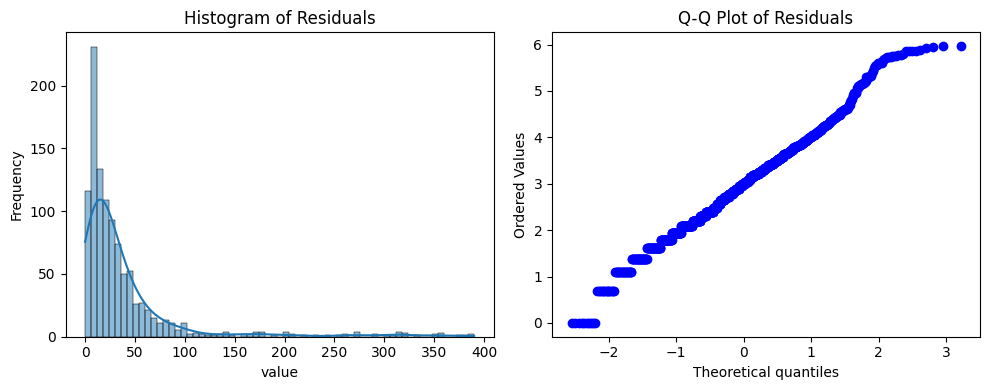

Shapiro-Wilk p-value: 1.0


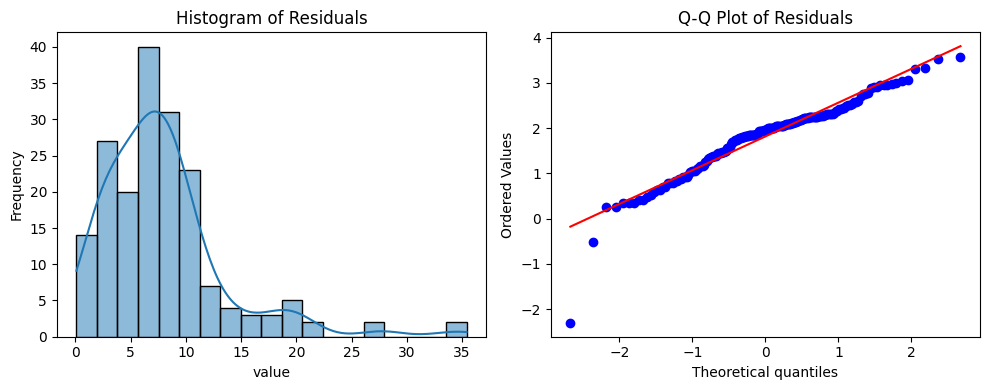

Shapiro-Wilk p-value: 2.7191461526854255e-07


In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

residuals = WW["N1 Copies/L"]
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True)
plt.xlabel('value')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')

plt.subplot(1, 2, 2)
stats.probplot(np.log(residuals), plot=plt)
plt.title('Q-Q Plot of Residuals')

plt.tight_layout()
plt.show()

_, p_value = stats.shapiro(np.log(residuals))
print("Shapiro-Wilk p-value:", p_value)

residuals = ts_case.y
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True)
plt.xlabel('value')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')

plt.subplot(1, 2, 2)
stats.probplot(np.log(residuals), plot=plt)
plt.title('Q-Q Plot of Residuals')

plt.tight_layout()
plt.show()

_, p_value = stats.shapiro(np.log(residuals))
print("Shapiro-Wilk p-value:", p_value)


residuals = ts_Hosp.y
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True)
plt.xlabel('value')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')

plt.subplot(1, 2, 2)
stats.probplot(np.log(residuals), plot=plt)
plt.title('Q-Q Plot of Residuals')

plt.tight_layout()
plt.show()

_, p_value = stats.shapiro(np.log(residuals))
print("Shapiro-Wilk p-value:", p_value)

residuals = ts_USA_CDC['WEEKLY RATE']
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True)
plt.xlabel('value')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')

plt.subplot(1, 2, 2)
stats.probplot(np.log(residuals), plot=plt)
plt.title('Q-Q Plot of Residuals')

plt.tight_layout()
plt.show()

_, p_value = stats.shapiro(np.log(residuals))
print("Shapiro-Wilk p-value:", p_value)


The present methodology involves the calculation of confidence intervals for the mean of each time series, thereby enabling the incorporation of uncertainty in the identification of peaks above and below average for a particular geographical region.

In [ ]:
import scipy.stats as stats

#Bronx wastewater
# Set the parameters
data = WW["N1 Copies/L"]  # Replace with your actual data

# Calculate the sample size
sample_size = len(data)

# Calculate the sample mean and standard deviation
sample_mean = np.mean(data)
sample_std = np.std(data, ddof=1)  # ddof=1 for unbiased estimation

# Set the desired confidence level
confidence_level = 0.99

# Calculate the t-value for the desired confidence level
t_value = stats.t.ppf((1 + confidence_level) / 2, df=sample_size - 1)

# Calculate the standard error of the mean
standard_error = sample_std / np.sqrt(sample_size)

# Calculate the margin of error
margin_of_error = t_value * standard_error

# Calculate the lower and upper bounds of the confidence interval
lower_bound = sample_mean - margin_of_error
upper_bound = sample_mean + margin_of_error

# Print the confidence interval
print("99% Confidence Interval: [{:.4f}, {:.4f}]".format(lower_bound, upper_bound))

#Bronx cases

# Set the parameters
data = ts_case.y  # Replace with your actual data

# Calculate the sample size
sample_size = len(data)

# Calculate the sample mean and standard deviation
sample_mean = np.mean(data)
sample_std = np.std(data, ddof=1)  # ddof=1 for unbiased estimation

# Set the desired confidence level
confidence_level = 0.99

# Calculate the t-value for the desired confidence level
t_value = stats.t.ppf((1 + confidence_level) / 2, df=sample_size - 1)

# Calculate the standard error of the mean
standard_error = sample_std / np.sqrt(sample_size)

# Calculate the margin of error
margin_of_error = t_value * standard_error

# Calculate the lower and upper bounds of the confidence interval
lower_bound = sample_mean - margin_of_error
upper_bound = sample_mean + margin_of_error

# Print the confidence interval
print("99% Confidence Interval: [{:.4f}, {:.4f}]".format(lower_bound, upper_bound))

#Bronx hospitilization

# Set the parameters
data = ts_Hosp.y  # Replace with your actual data

# Calculate the sample size
sample_size = len(data)

# Calculate the sample mean and standard deviation
sample_mean = np.mean(data)
sample_std = np.std(data, ddof=1)  # ddof=1 for unbiased estimation

# Set the desired confidence level
confidence_level = 0.99

# Calculate the t-value for the desired confidence level
t_value = stats.t.ppf((1 + confidence_level) / 2, df=sample_size - 1)

# Calculate the standard error of the mean
standard_error = sample_std / np.sqrt(sample_size)

# Calculate the margin of error
margin_of_error = t_value * standard_error

# Calculate the lower and upper bounds of the confidence interval
lower_bound = sample_mean - margin_of_error
upper_bound = sample_mean + margin_of_error

# Print the confidence interval
print("99% Confidence Interval: [{:.4f}, {:.4f}]".format(lower_bound, upper_bound))

99% Confidence Interval: [6174.9535, 11820.4774]
99% Confidence Interval: [341.6158, 491.2574]
99% Confidence Interval: [33.1424, 42.2041]


# Main text. Figure 1 subplots A->C:
Congruence between wastewater and hospital-recorded cases.

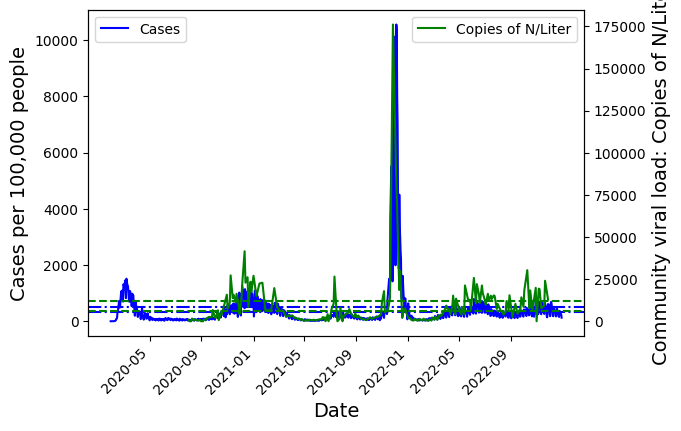

In [ ]:
plt.style.use('default')
fig,ax = plt.subplots()
# make a plot
Cases = ax.plot(ts_case.index,
        ts_case.y,
        color="blue", label = "Cases")
ax.axhline(y=341.6158, color='blue', linestyle='-.')
ax.axhline(y=491.2574, color='blue', linestyle='-.')
# set x-axis label
ax.set_xlabel("Date", fontsize = 14)
# set y-axis label
ax.set_ylabel("Cases per 100,000 people",
              color="black",
              fontsize=14)

ax2=ax.twinx()

# make a plot with different y-axis using second axis object
#ax2.plot(WW2.index, WW2["N1 Copies/L"],color='green')
sewage = ax2.plot(WW.index, WW["N1 Copies/L"],color='green', label = "Copies of N/Liter")
ax2.axhline(y=6174.9535, color='green', linestyle='--')
ax2.axhline(y=11820.4774, color='green', linestyle='--')
ax2.legend(loc='upper right')
ax2.set_ylabel("Community viral load: Copies of N/Liter",color="black",fontsize=14)
ax.legend( loc='upper left')
ax2.legend(loc='upper right')
fig.autofmt_xdate(rotation=45)
plt.xticks(
    rotation=45,
    ticks=pd.date_range(start='2020-05', end='2023-01', freq='4M'),
    labels=pd.date_range(start='2020-05', end='2023-01', freq='4M').strftime('%Y-%m'))
plt.savefig("viral_load_and_cases.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
# Set the parameters
data = ts_USA_CDC['WEEKLY RATE']  # Replace with your actual data
confidence_level = 0.99
sample_size = len(data)
num_bootstrap_samples = 1000000  # Number of bootstrap samples

# Function to calculate the bootstrap median
def bootstrap_median(data):
    bootstrap_samples = np.random.choice(data, size=len(data), replace=True)
    return np.median(bootstrap_samples)

# Generate bootstrap samples and calculate bootstrap medians
bootstrap_medians = []
for _ in range(num_bootstrap_samples):
    bootstrap_medians.append(bootstrap_median(data))

# Calculate the lower and upper bounds of the bootstrap confidence interval
lower_bound = np.percentile(bootstrap_medians, (1 - confidence_level) / 2 * 100)
upper_bound = np.percentile(bootstrap_medians, (1 + confidence_level) / 2 * 100)

# Print the bootstrap confidence interval
print("{:.2f}% Bootstrap Confidence Interval for Median: [{:.4f}, {:.4f}]".format(
    confidence_level * 100, lower_bound, upper_bound))


99.00% Bootstrap Confidence Interval for Median: [6.2000, 7.8000]


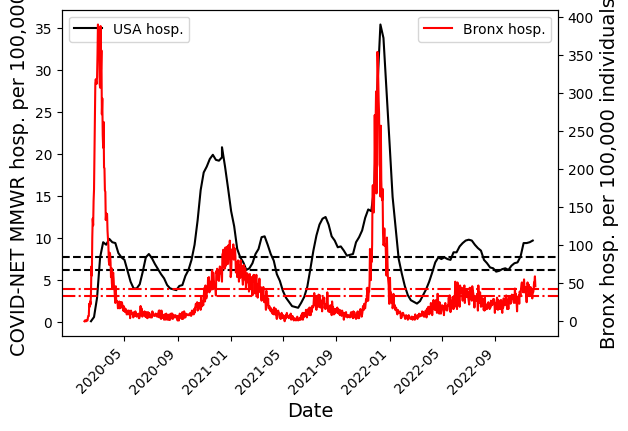

In [ ]:
USA_h = ts_USA_CDC
end_date = '2023-01'
mask = (USA_h.index < end_date)
USA_h = USA_h.loc[mask]
mask = (ts_Hosp.index < end_date)
ts_Hosp = ts_Hosp.loc[mask]
mask = (NYS_ts.index < end_date)
NYS_ts = NYS_ts.loc[mask]
plt.style.use('default')
fig,ax = plt.subplots()
# make a plot
USA = ax.plot(USA_h.index,
        USA_h['WEEKLY RATE'],
        color="black", label = "USA hosp.")
ax.axhline(y=6.2, color='black', linestyle='--')
ax.axhline(y=7.8, color='black', linestyle='--')
ax.set_xlabel("Date", fontsize = 14)
# set y-axis label
ax.set_ylabel("COVID-NET MMWR hosp. per 100,000",
              color="black",
              fontsize=14)

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
local = ax2.plot(ts_Hosp.index, ts_Hosp.y ,color='red', label = "Bronx hosp.")
ax2.axhline(y=33.1424, color='red', linestyle='-.')
ax2.axhline(y=42.2041, color='red', linestyle='-.')
ax2.legend(loc='upper right')
ax2.set_ylabel("Bronx hosp. per 100,000 individuals",color="black",fontsize=14)
ax.legend( loc='upper left')
ax2.legend(loc='upper right')
fig.autofmt_xdate(rotation=45)
plt.xticks(
    rotation=45,
    ticks=pd.date_range(start='2020-05', end='2023-01', freq='4M'),
    labels=pd.date_range(start='2020-05', end='2023-01', freq='4M').strftime('%Y-%m'))
plt.savefig("Hosp_data.pdf", format="pdf", bbox_inches="tight")
plt.show()

                Baseline_hosp.
CATCHMENT                     
California            7.294231
Colorado             12.350549
Connecticut           7.288645
Entire Network        9.223352
Georgia               7.364835
Iowa                  8.119780
Maryland              8.157692
Michigan              8.115110
Minnesota             9.047253
New Mexico           10.021978
New York              4.343956
Ohio                  5.134615
Oregon                8.439286
Tennessee             6.189560
Utah                  6.145330


<ipython-input-8-933d383e707a>:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  / weekly_series_CDC.mean(axis=1)[:, np.newaxis])


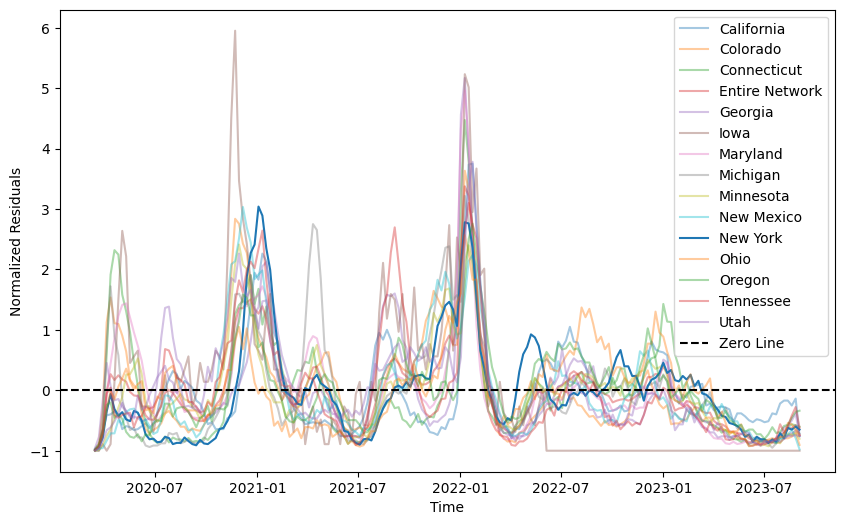

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Get the number of columns in your data
num_columns = weekly_series_CDC_transposed.shape[1]  # Subtract 1 to exclude 'time' column

# Initialize an array to store growth rates for each column
baselines = np.zeros(num_columns)

# Calculate the growth rate for each column using percentage change
for i in range(num_columns):  # Start from index 1 to exclude 'time'
    baseline = np.mean(weekly_series_CDC_transposed.iloc[:, i])
    baselines[i-1] = baseline

# Create a DataFrame with preserved column names
baselines_tot_df = pd.DataFrame(baselines, index=weekly_series_CDC_transposed.columns, columns=['Baseline_hosp.'])

print(baselines_tot_df)

# Calculate the residuals relative to the mean of the time series, normalized by the mean
residuals = (weekly_series_CDC.sub(weekly_series_CDC.mean(axis=1), axis=0)
             / weekly_series_CDC.mean(axis=1)[:, np.newaxis])

# Plot the normalized residuals over time
plt.figure(figsize=(10, 6))

# Plot the residuals for each series
for i, (state, data) in enumerate(residuals.iterrows()):
    if state == 'New York':
        plt.plot(data.index, data.values, label=f'{state}', alpha=1)
    else:
        plt.plot(data.index, data.values, label=f'{state}', alpha=0.4)

# Add a horizontal dotted line at y=0
plt.axhline(y=0, color='black', linestyle='--', label='Zero Line')

plt.xlabel('Time')
plt.ylabel('Normalized Residuals')
plt.legend()
plt.savefig("Normalized_Residuals.pdf", format="pdf", bbox_inches="tight")
plt.show()



# Section 2. Not included in text: Are statewide vaccination levels linked to a reduction in hospitalizations during the second year?  
Comparing statewide ranking in hospitalizations and vaccinations is important to assess the impact of vaccination levels on the state-wide variability. If there is a strong negative correlation between rankings of states the variability can likely be explained away as the level of vaccination a community/state receives determines the variability in hospitalizations. The code below looks at the average, minimum, and maximum growth rates of vaccination (logistic process) and compares them to the average case rate (stochastic process) during the second year.

In [4]:
import numpy as np
import matplotlib.pyplot as plt

mask = ts_vax_CDC.columns.isin(weekly_series_CDC_transposed.columns)
ts_vax_CDC = ts_vax_CDC.loc[:, mask]
mask = weekly_series_CDC_transposed.columns.isin(ts_vax_CDC.columns)
weekly_series_CDC_transposed = weekly_series_CDC_transposed.loc[:, mask]


ts_vax_CDC = ts_vax_CDC.ffill()
ts_vax_CDC = ts_vax_CDC.fillna(0)

# Plot the normalized residuals over time
plt.figure(figsize=(10, 6))

# Plot the residuals for each series
for i, (state, data) in enumerate(ts_vax_CDC.T.iterrows()):
    plt.plot(data.index, data.values, label=f'{state}')

# Add a horizontal dotted line at y=0
plt.xlabel('Time')
plt.ylabel('Vaccinations percent')
plt.legend()
plt.savefig("vax_ts.pdf", format="pdf", bbox_inches="tight")
plt.show()



NameError: name 'ts_vax_CDC' is not defined

In [ ]:

common_dates = ts_vax_CDC.index.intersection(weekly_series_CDC_transposed.index)

# Filter each DataFrame to keep only rows with common dates
ts_vax_CDC_filtered = ts_vax_CDC[ts_vax_CDC.index.isin(common_dates)]
weekly_series_CDC_transposed_filtered = weekly_series_CDC_transposed[weekly_series_CDC_transposed.index.isin(common_dates)]


ts_vax_CDC_filtered = ts_vax_CDC_filtered[ts_vax_CDC_filtered.mean().sort_values().index]
weekly_series_CDC_transposed_filtered = weekly_series_CDC_transposed_filtered[weekly_series_CDC_transposed_filtered.mean().sort_values().index]


ts_vax_CDC_filtered = ts_vax_CDC_filtered[ts_vax_CDC_filtered.mean().sort_values().index]
weekly_series_CDC_transposed_filtered = weekly_series_CDC_transposed_filtered[weekly_series_CDC_transposed_filtered.mean().sort_values().index]



location    California  Colorado  Connecticut  Georgia   Iowa  Maryland  \
date                                                                      
2020-12-20        0.00      0.00         0.00     0.00   0.00      0.00   
2020-12-27        0.00      0.00         0.00     0.00   0.00      0.00   
2021-01-03        0.00      0.00         0.00     0.00   0.00      0.00   
2021-01-10        0.00      0.00         0.00     0.00   0.00      0.00   
2021-01-17        0.52      0.82         0.48     0.21   0.34      0.26   
...                ...       ...          ...      ...    ...       ...   
2023-04-09       74.82     73.67        83.15    57.42  64.49     79.88   
2023-04-16       74.84     73.69        83.16    57.43  64.50     79.90   
2023-04-23       74.85     73.71        83.17    57.45  64.51     79.92   
2023-04-30       74.86     73.71        83.19    57.46  64.53     79.94   
2023-05-07       74.87     73.75        83.20    57.47  64.54     79.96   

location    Michigan  Mi

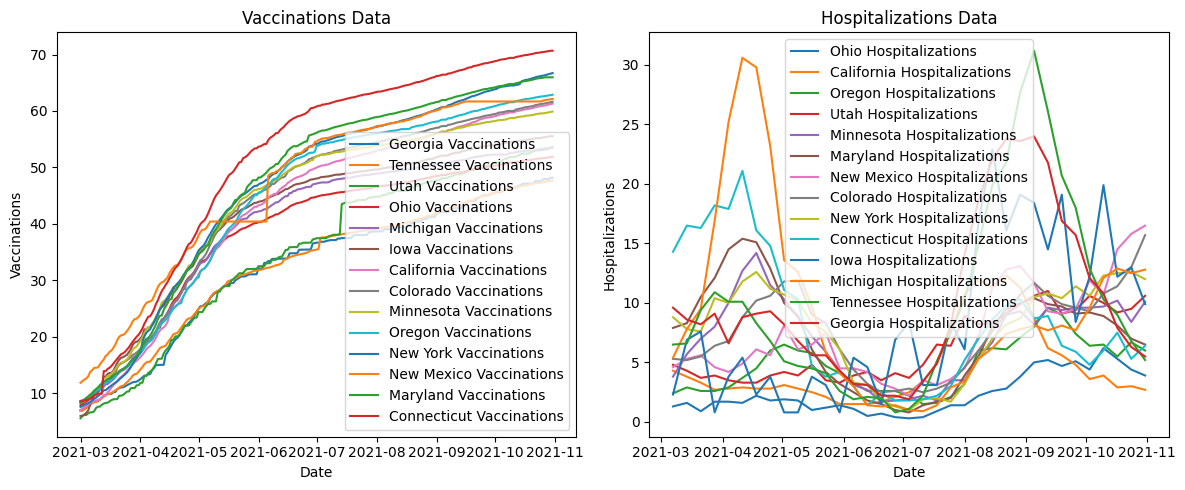

In [ ]:
import pandas as pd
import numpy as np
from scipy.signal import correlate, correlation_lags
import matplotlib.pyplot as plt

# Assuming ts_vax_CDC and weekly_series_CDC_transposed are defined

# Define the date range from March 2021 to November 2021
start_date = '2021-03-01'
end_date = '2021-10-31'

# Filter the data for the specified date range
ts_vax_CDC_filtered = ts_vax_CDC[(ts_vax_CDC.index >= start_date) & (ts_vax_CDC.index <= end_date)]
weekly_series_CDC_transposed_filtered = weekly_series_CDC_transposed[(weekly_series_CDC_transposed.index >= start_date) & (weekly_series_CDC_transposed.index <= end_date)]

# Sort columns based on mean values for both DataFrames
ts_vax_CDC_filtered = ts_vax_CDC_filtered[ts_vax_CDC_filtered.mean().sort_values().index]
weekly_series_CDC_transposed_filtered = weekly_series_CDC_transposed_filtered[weekly_series_CDC_transposed_filtered.mean().sort_values().index]

# Plot the cross-correlation results
plt.figure(figsize=(12, 5))

# Plot Vaccinations Data
plt.subplot(1, 2, 1)
for col in ts_vax_CDC_filtered.columns:
    plt.plot(ts_vax_CDC_filtered.index, ts_vax_CDC_filtered[col], label=f'{col} Vaccinations')
plt.xlabel('Date')
plt.ylabel('Vaccinations')
plt.title('Vaccinations Data')
plt.legend()

# Plot Hospitalizations Data
plt.subplot(1, 2, 2)
for col in weekly_series_CDC_transposed_filtered.columns:
    plt.plot(weekly_series_CDC_transposed_filtered.index, weekly_series_CDC_transposed_filtered[col], label=f'{col} Hospitalizations')
plt.xlabel('Date')
plt.ylabel('Hospitalizations')
plt.title('Hospitalizations Data')
plt.legend()

plt.tight_layout()
plt.show()



In [ ]:
import pandas as pd
import numpy as np

# Convert 'time' to numerical representation
time_numeric = pd.to_numeric(ts_vax_CDC_filtered.index)

# Get the number of columns in your data
num_columns = ts_vax_CDC_filtered.shape[1]  # Subtract 1 to exclude 'time' column

# Initialize an array to store growth rates for each column
growth_rates = np.zeros(num_columns)

# Calculate the growth rate for each column using percentage change
for i in range(num_columns):  # Start from index 1 to exclude 'time'
    geometric_mean = np.exp(np.mean(np.log(ts_vax_CDC_filtered.iloc[:, i])))
    growth_rates[i-1] = geometric_mean

# Create a DataFrame with preserved column names
growth_rates_df = pd.DataFrame(growth_rates, index=ts_vax_CDC_filtered.columns, columns=['Average Growth Rate'])

print(growth_rates_df)

             Average Growth Rate
location                        
Georgia                29.481006
Tennessee              30.361659
Utah                   35.425317
Ohio                   36.527762
Michigan               37.875275
Iowa                   37.770241
California             39.675000
Colorado               40.095253
Minnesota              39.686889
Oregon                 41.055425
New York               43.498174
New Mexico             41.979075
Maryland               45.929358
Connecticut            29.037241


In [ ]:
# Assuming 'time' is the index of ts_vax_CDC_filtered
# Remove duplicate columns
ts_vax_CDC_filtered = ts_vax_CDC_filtered.loc[:, ~ts_vax_CDC_filtered.columns.duplicated()]

# Find the index of the row with minimum values across all columns
min_row_index = ts_vax_CDC_filtered.idxmin()

# Use loc or iloc to access the entire row
min_row = ts_vax_CDC_filtered.loc[min_row_index]

# Transpose the Series to convert it to a DataFrame with preserved column names
min_row_df = pd.DataFrame(min_row).T.loc[:, ~pd.DataFrame(min_row).T.columns.duplicated()]

# Rename the column to 'min'
min_row_df.columns = ['min']

# Print the DataFrame
print(min_row_df)

# Assuming 'time' is the index of ts_vax_CDC_filtered
# Remove duplicate columns
ts_vax_CDC_filtered = ts_vax_CDC_filtered.loc[:, ~ts_vax_CDC_filtered.columns.duplicated()]

# Find the index of the row with maximum values across all columns
max_row_index = ts_vax_CDC_filtered.idxmax()

# Use loc or iloc to access the entire row
max_row = ts_vax_CDC_filtered.loc[max_row_index]

# Transpose the Series to convert it to a DataFrame with preserved column names
max_row_df = pd.DataFrame(max_row).T.loc[:, ~pd.DataFrame(max_row).T.columns.duplicated()]

# Select the first column and rename the column to 'max'
max_row_df = max_row_df.iloc[:, 0].to_frame(name='max')

# Print the DataFrame
print(max_row_df)



               min
location          
Georgia       7.00
Tennessee     6.86
Utah          5.55
Ohio          7.87
Michigan      8.61
Iowa          5.96
California    6.94
Colorado      8.33
Minnesota     8.33
Oregon        8.63
New York      7.58
New Mexico   11.86
Maryland      8.33
Connecticut   8.58
               max
location          
Georgia      48.19
Tennessee    47.66
Utah         53.58
Ohio         51.88
Michigan     53.54
Iowa         55.55
California   61.31
Colorado     61.64
Minnesota    59.90
Oregon       62.88
New York     66.72
New Mexico   62.14
Maryland     65.97
Connecticut  70.68


In [ ]:
import pandas as pd
import numpy as np

# Convert 'time' to numerical representation
time_numeric = pd.to_numeric(weekly_series_CDC_transposed_filtered.index)

# Get the number of columns in your data
num_columns =weekly_series_CDC_transposed_filtered.shape[1]  # Subtract 1 to exclude 'time' column

# Initialize an array to store growth rates for each column
growth_rates = np.zeros(num_columns)

# Calculate the growth rate for each column using percentage change
for i in range(num_columns):  # Start from index 1 to exclude 'time'
    baseline = np.mean(weekly_series_CDC_transposed_filtered.iloc[:, i])
    growth_rates[i-1] = baseline

# Create a DataFrame with preserved column names
baselines_df = pd.DataFrame(growth_rates, index=weekly_series_CDC_transposed_filtered.columns, columns=['Baseline_hosp.'])

print(baselines_df)

             Baseline_hosp.
CATCHMENT                  
Ohio               4.617143
California         4.768571
Oregon             6.340000
Utah               7.051429
Minnesota          7.357143
Maryland           7.388571
New Mexico         7.714286
Colorado           7.848571
New York           8.217143
Connecticut        8.348571
Iowa               9.402857
Michigan           9.920000
Tennessee         10.057143
Georgia            2.365714


Kendall's Tau Correlation: 0.0330
P-value: 0.9145


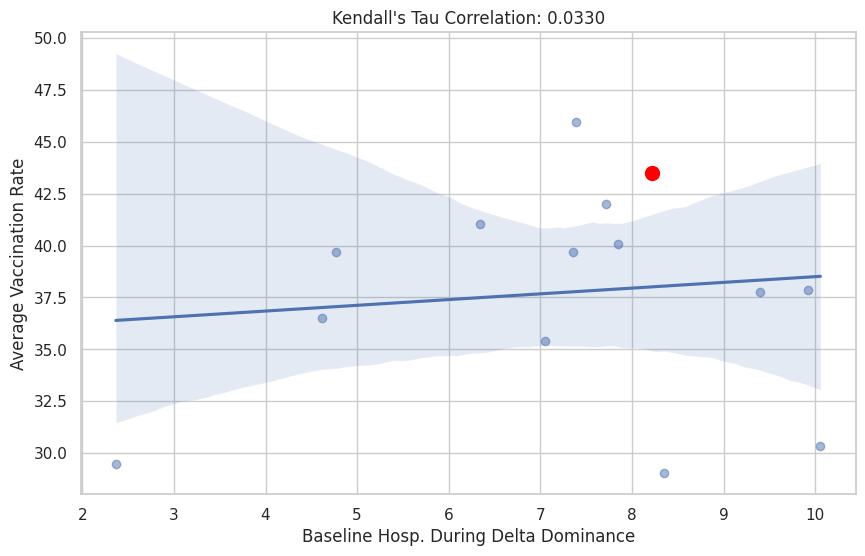

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import kendalltau
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure row orders match by aligning the DataFrames on their indices
aligned_data = pd.concat([baselines_df['Baseline_hosp.'], growth_rates_df['Average Growth Rate']], axis=1, join='inner')

# Calculate the Kendall's Tau correlation
correlation, p_value = kendalltau(aligned_data['Baseline_hosp.'], aligned_data['Average Growth Rate'])

# Print the correlation coefficient and p-value
print(f"Kendall's Tau Correlation: {correlation:.4f}")
print(f"P-value: {p_value:.4f}")

# Create a scatter plot with regression line
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.regplot(x='Baseline_hosp.', y='Average Growth Rate', data=aligned_data, scatter_kws={'alpha': 0.5})

# Highlight the point for New York
ny_data = aligned_data.loc['New York']
plt.scatter(ny_data['Baseline_hosp.'], ny_data['Average Growth Rate'], color='red', label='New York', s=100)

plt.title(f"Kendall's Tau Correlation: {correlation:.4f}")
plt.xlabel('Baseline Hosp. During Delta Dominance')
plt.ylabel('Average Vaccination Rate')
plt.savefig("vax_hosp_cor.pdf", format="pdf", bbox_inches="tight")
plt.show()

Kendall's Tau Correlation: 0.0670
P-value: 0.7412


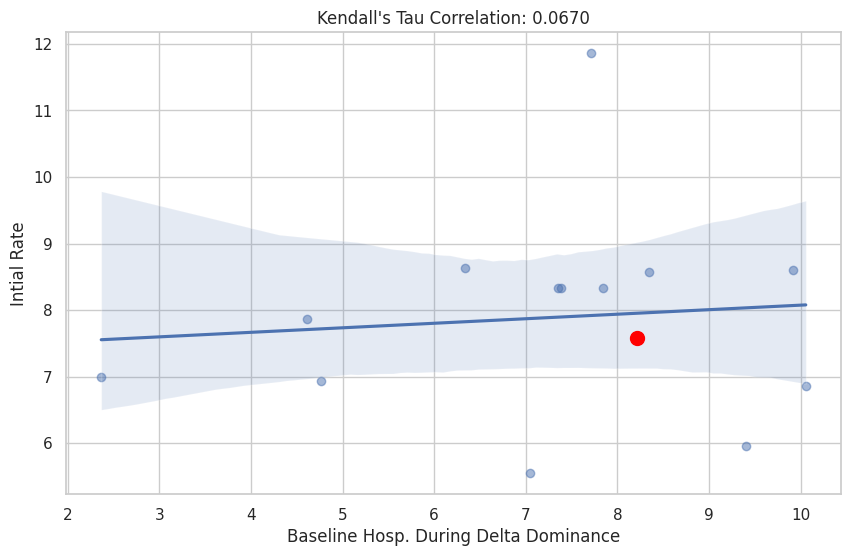

Kendall's Tau Correlation: 0.1209
P-value: 0.5906


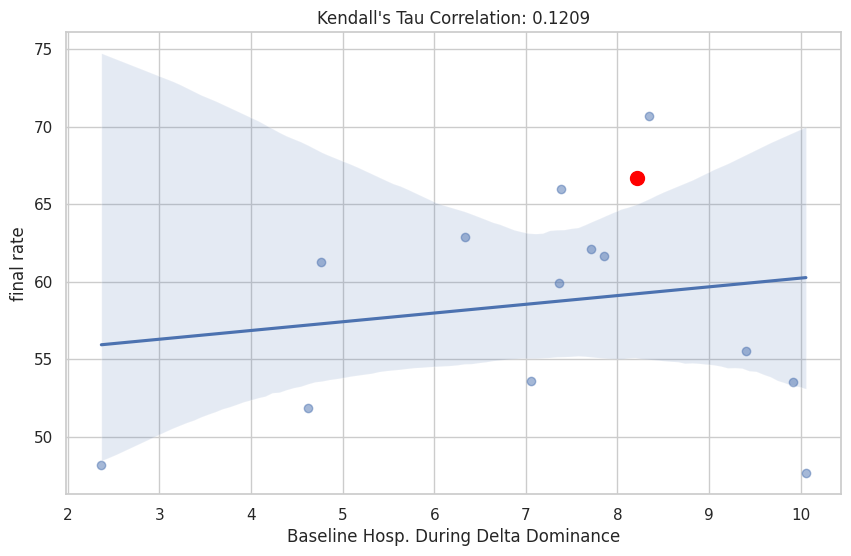

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import kendalltau
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure row orders match by aligning the DataFrames on their indices
aligned_data = pd.concat([min_row_df['min'], baselines_df['Baseline_hosp.']], axis=1, join='inner')

# Calculate the Kendall's Tau correlation
correlation, p_value = kendalltau(aligned_data['Baseline_hosp.'], aligned_data['min'])

# Print the correlation coefficient and p-value
print(f"Kendall's Tau Correlation: {correlation:.4f}")
print(f"P-value: {p_value:.4f}")

# Create a scatter plot with regression line
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.regplot(x='Baseline_hosp.', y='min', data=aligned_data, scatter_kws={'alpha': 0.5})

# Highlight the point for New York
ny_data = aligned_data.loc['New York']
plt.scatter(ny_data['Baseline_hosp.'], ny_data['min'], color='red', label='New York', s=100)

plt.title(f"Kendall's Tau Correlation: {correlation:.4f}")
plt.xlabel('Baseline Hosp. During Delta Dominance')
plt.ylabel('Intial Rate')
plt.show()

import pandas as pd
import numpy as np
from scipy.stats import kendalltau
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure row orders match by aligning the DataFrames on their indices
aligned_data = pd.concat([max_row_df['max'], baselines_df['Baseline_hosp.']], axis=1, join='inner')

# Calculate the Kendall's Tau correlation
correlation, p_value = kendalltau(aligned_data['max'], aligned_data['Baseline_hosp.'])

# Print the correlation coefficient and p-value
print(f"Kendall's Tau Correlation: {correlation:.4f}")
print(f"P-value: {p_value:.4f}")

# Create a scatter plot with regression line
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.regplot(x='Baseline_hosp.', y='max', data=aligned_data, scatter_kws={'alpha': 0.5})

# Highlight the point for New York
ny_data = aligned_data.loc['New York']
plt.scatter(ny_data['Baseline_hosp.'], ny_data['max'], color='red', label='New York', s=100)

plt.title(f"Kendall's Tau Correlation: {correlation:.4f}")
plt.xlabel('Baseline Hosp. During Delta Dominance')
plt.ylabel('final rate')
plt.show()

# Section 3. Genomic data analyses

In [3]:
nextclade = pd.read_csv('nextclade_02-14-23.csv', sep=';')

# Get rid of first column, contains index values that will not be used
nextclade['Collection date'] = nextclade['seqName'].apply(lambda x: x.split('|')[2])
nextclade.drop_duplicates(inplace=True)
nextclade

seqName          clade  \
0     hCoV-19/USA/NY-Wadsworth-21008553-01/2021|EPI_...            20C   
1     hCoV-19/USA/NY-Wadsworth-21008557-01/2021|EPI_...            20B   
2     hCoV-19/USA/NY-Wadsworth-21012067-01/2021|EPI_...            20A   
3     hCoV-19/USA/NY-NYUMC161/2020|EPI_ISL_424968|20...            20C   
4     hCoV-19/USA/NY-AECOM_134/2020|EPI_ISL_826668|2...            20B   
...                                                 ...            ...   
2786  hCoV-19/USA/NY-Wadsworth-22001094-01/2021|EPI_...  21K (Omicron)   
2787  hCoV-19/USA/NY-Wadsworth-21109405-01/2021|EPI_...  21K (Omicron)   
2788  hCoV-19/USA/NY-Wadsworth-21104650-01/2021|EPI_...    21J (Delta)   
2789  hCoV-19/USA/NY-Wadsworth-21109513-01/2021|EPI_...  21K (Omicron)   
2790  hCoV-19/USA/NY-Yale-15734/2022|EPI_ISL_9084260...  21K (Omicron)   

     Nextclade_pango partiallyAliased clade_nextstrain   clade_who  \
0            B.1.637          B.1.637              20C  unassigned   
1          B.1.1.434        B.1.1.434              20B  unassigned   
2            B.1.234          B.1.234              20A  unassigned   
3                B.1              B.1              20C  unassigned   
4              B.1.1            B.1.1              20B  unassigned   
...              ...              ...              ...         ...   
2786          BA.1.1           BA.1.1              21K     Omicron   
2787         BA.1.15          BA.1.15              21K     Omicron   
2788            AY.3      B.1.617.2.3              21J       Delta   
2789         BA.1.17          BA.1.17              21K     Omicron   
2790          BA.1.1           BA.1.1              21K     Omicron   

       clade_legacy  qc.overallScore qc.overallStatus  totalSubstitutions  \
0               20C         0.000000             good                  26   
1               20B         0.000000             good                  18   
2               20A        11.111111             good                  19   
3               20C         0.000000             good                   7   
4               20B         0.000000             good                  12   
...             ...              ...              ...                 ...   
2786  21K (Omicron)         0.126420             good                  56   
2787  21K (Omicron)         0.288409             good                  55   
2788    21J (Delta)         1.562500             good                  46   
2789  21K (Omicron)         2.161989             good                  54   
2790  21K (Omicron)         0.000000             good                  59   

      ...  qc.frameShifts.status  qc.stopCodons.stopCodons  \
0     ...                   good                       NaN   
1     ...                   good                       NaN   
2     ...                   good                       NaN   
3     ...                   good                       NaN   
4     ...                   good                       NaN   
...   ...                    ...                       ...   
2786  ...                   good                       NaN   
2787  ...                   good                       NaN   
2788  ...                   good                       NaN   
2789  ...                   good                       NaN   
2790  ...                   good                       NaN   

      qc.stopCodons.totalStopCodons  qc.stopCodons.score  \
0                                 0                    0   
1                                 0                    0   
2                                 0                    0   
3                                 0                    0   
4                                 0                    0   
...                             ...                  ...   
2786                              0                    0   
2787                              0                    0   
2788                              0                    0   
2789                              0             

In [4]:
from functools import reduce

nextclade_omi = nextclade[nextclade['clade_who'].str.contains('Omicron')]

nextclade_omi['aaSubstitutions'] = nextclade_omi['aaSubstitutions'].apply(lambda x: x.split(','))

# use reduce to iteratively apply the union function to all the lists in the column
mutations_union = reduce(lambda x, y: set(x).union(set(y)), nextclade_omi['aaSubstitutions'])

data = []

# iterate through the set and split each string on the colon character
for mutation in mutations_union:
    gene, amino_acid_change = mutation.split(':')
    data.append({'Gene': gene, 'Amino Acid Change': amino_acid_change})

# create a pandas DataFrame from the data
Omicron_mutation = pd.DataFrame(data)
print(Omicron_mutation)




nextclade_delta = nextclade[nextclade['clade_who'].str.contains('Delta')]

nextclade_delta['aaSubstitutions'] = nextclade_delta['aaSubstitutions'].apply(lambda x: x.split(','))

# use reduce to iteratively apply the union function to all the lists in the column
Delta_mutations_union = reduce(lambda x, y: set(x).union(set(y)), nextclade_delta['aaSubstitutions'])

data = []

# iterate through the set and split each string on the colon character
for mutation in Delta_mutations_union:
    gene, amino_acid_change = mutation.split(':')
    data.append({'Gene': gene, 'Amino Acid Change': amino_acid_change})

# create a pandas DataFrame from the data
Delta_mutation = pd.DataFrame(data)
print(Delta_mutation)


      Gene Amino Acid Change
0        S             F486S
1    ORF1a              R99H
2    ORF1a            D3972G
3        S             G476S
4    ORF1a             L642F
..     ...               ...
583      S            I1221V
584  ORF3a             S165F
585  ORF1b             G376S
586  ORF1b            C2341F
587      S             P681H

[588 rows x 2 columns]
      Gene Amino Acid Change
0        S             F486S
1        S             S221L
2    ORF1a            N1123S
3        S             S704L
4    ORF1a            P1640F
..     ...               ...
549  ORF1b             M809I
550  ORF3a             S165F
551      N             G179S
552  ORF1a            H3580Q
553      S            K1073N

[554 rows x 2 columns]


<ipython-input-4-288f028e295b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nextclade_omi['aaSubstitutions'] = nextclade_omi['aaSubstitutions'].apply(lambda x: x.split(','))
<ipython-input-4-288f028e295b>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nextclade_delta['aaSubstitutions'] = nextclade_delta['aaSubstitutions'].apply(lambda x: x.split(','))


In [5]:
# Wuhan reference genome is 29903 nts in length
# Code is meant for SAAP heatmap of entire genome
# Numbering of AA position restarts for every gene
df_S_rows = {}
df_ORF1ab_rows = {}
df_ORF3a_rows = {}
df_E_rows = {}
df_M_rows = {}
df_ORF6_rows = {}
df_ORF7a_rows = {}
df_ORF7b_rows = {}
df_ORF8_rows = {}
df_N_rows = {}
df_ORF10_rows = {}

count = 0
for row in nextclade['aaSubstitutions']:
    list_subs = row.split(',')
    count_muts = {}
    current_seq = nextclade['seqName'][count]

    # Fills in zeroes for every AA position in every gene
    df_ORF1ab_rows[current_seq] = {**{(k): 0 for k in range(1, 7096)}}
    df_S_rows[current_seq] = {**{(k): 0 for k in range(1, 1274)}}
    df_ORF3a_rows[current_seq] = {**{(k): 0 for k in range(1, 276)}}
    df_E_rows[current_seq] = {**{(k): 0 for k in range(1, 76)}}
    df_M_rows[current_seq] = {**{(k): 0 for k in range(1, 223)}}
    df_ORF6_rows[current_seq] = {**{(k): 0 for k in range(1, 62)}}
    df_ORF7a_rows[current_seq] = {**{(k): 0 for k in range(1, 122)}}
    df_ORF7b_rows[current_seq] = {**{(k): 0 for k in range(1, 45)}}
    df_ORF8_rows[current_seq] = {**{(k): 0 for k in range(1, 122)}}
    df_N_rows[current_seq] = {**{(k): 0 for k in range(1, 420)}}
    df_ORF10_rows[current_seq] = {**{(k): 0 for k in range(1, 39)}}

    for sub in list_subs:

        # Use Regex to find gene notation included in AA sub
        gene = re.match('^[^:]+\s*', sub)[0]

        # Use Regex to find AA position in AA sub
        aa = int(re.findall(r':[A-Z](\d+)', (sub))[0])

        # Change value of AA position in gene to 1 if SAAP exists
        if gene == 'S':
            df_S_rows[current_seq][aa] = 1
        elif gene == 'ORF1a' or gene == 'ORF1b':
            if gene == 'ORF1b':
                aa += 4405
            df_ORF1ab_rows[current_seq][aa] = 1
        elif gene == 'ORF3a':
            df_ORF3a_rows[current_seq][aa] = 1
        elif gene == 'E':
            df_E_rows[current_seq][aa] = 1
        elif gene == 'M':
            df_M_rows[current_seq][aa] = 1
        elif gene == 'ORF6':
            df_ORF6_rows[current_seq][aa] = 1
        elif gene == 'ORF7a':
            df_ORF7a_rows[current_seq][aa] = 1
        elif gene == 'ORF7b':
            df_ORF7b_rows[current_seq][aa] = 1
        elif gene == 'ORF8':
            df_ORF8_rows[current_seq][aa] = 1
        elif gene == 'N':
            df_N_rows[current_seq][aa] = 1
        elif gene == 'ORF10':
            df_ORF10_rows[current_seq][aa] = 1

    count+=1

ORF1ab_SAAP_bronx = pd.DataFrame.from_dict(df_ORF1ab_rows, orient='index')
S_SAAP_bronx = pd.DataFrame.from_dict(df_S_rows, orient='index')
ORF3a_SAAP_bronx = pd.DataFrame.from_dict(df_ORF3a_rows, orient='index')
E_SAAP_bronx = pd.DataFrame.from_dict(df_E_rows, orient='index')
M_SAAP_bronx = pd.DataFrame.from_dict(df_M_rows, orient='index')
ORF6_SAAP_bronx = pd.DataFrame.from_dict(df_ORF6_rows, orient='index')
ORF7a_SAAP_bronx = pd.DataFrame.from_dict(df_ORF7a_rows, orient='index')
ORF7b_SAAP_bronx = pd.DataFrame.from_dict(df_ORF7b_rows, orient='index')
ORF8_SAAP_bronx = pd.DataFrame.from_dict(df_ORF8_rows, orient='index')
N_SAAP_bronx = pd.DataFrame.from_dict(df_N_rows, orient='index')
ORF10_SAAP_bronx = pd.DataFrame.from_dict(df_ORF10_rows, orient='index')

# Concatenate all genes and their respective AA dataframe into one larger dataframe to produce heatmap
all_ORFs_SAAP = pd.concat([ORF1ab_SAAP_bronx, S_SAAP_bronx, ORF3a_SAAP_bronx, E_SAAP_bronx, M_SAAP_bronx, ORF6_SAAP_bronx,
                          ORF7a_SAAP_bronx, ORF7b_SAAP_bronx, ORF8_SAAP_bronx, N_SAAP_bronx, ORF10_SAAP_bronx], axis=1)

all_ORFs_SAAP


1   2   3   4   5   6   \
hCoV-19/USA/NY-Wadsworth-21008553-01/2021|EPI_I...   0   0   0   0   0   0   
hCoV-19/USA/NY-Wadsworth-21008557-01/2021|EPI_I...   0   0   0   0   0   0   
hCoV-19/USA/NY-Wadsworth-21012067-01/2021|EPI_I...   0   0   0   0   0   0   
hCoV-19/USA/NY-NYUMC161/2020|EPI_ISL_424968|202...   0   0   0   0   0   0   
hCoV-19/USA/NY-AECOM_134/2020|EPI_ISL_826668|20...   0   0   0   0   0   0   
...                                                 ..  ..  ..  ..  ..  ..   
hCoV-19/USA/NY-Wadsworth-22001094-01/2021|EPI_I...   0   0   0   0   0   0   
hCoV-19/USA/NY-Wadsworth-21109405-01/2021|EPI_I...   0   0   0   0   0   0   
hCoV-19/USA/NY-Wadsworth-21104650-01/2021|EPI_I...   0   0   0   0   0   0   
hCoV-19/USA/NY-Wadsworth-21109513-01/2021|EPI_I...   0   0   0   0   0   0   
hCoV-19/USA/NY-Yale-15734/2022|EPI_ISL_9084260|...   0   0   0   0   0   0   

                                                    7   8   9   10  ...  29  \
hCoV-19/USA/NY-Wadsworth-21008553-01/2021|EPI_I...   0   0   0   0  ...   0   
hCoV-19/USA/NY-Wadsworth-21008557-01/2021|EPI_I...   0   0   0   0  ...   0   
hCoV-19/USA/NY-Wadsworth-21012067-01/2021|EPI_I...   0   0   0   0  ...   0   
hCoV-19/USA/NY-NYUMC161/2020|EPI_ISL_424968|202...   0   0   0   0  ...   0   
hCoV-19/USA/NY-AECOM_134/2020|EPI_ISL_826668|20...   0   0   0   0  ...   0   
...                                                 ..  ..  ..  ..  ...  ..   
hCoV-19/USA/NY-Wadsworth-22001094-01/2021|EPI_I...   0   0   0   0  ...   0   
hCoV-19/USA/NY-Wadsworth-21109405-01/2021|EPI_I...   0   0   0   0  ...   0   
hCoV-19/USA/NY-Wadsworth-21104650-01/2021|EPI_I...   0   0   0   0  ...   0   
hCoV-19/USA/NY-Wadsworth-21109513-01/2021|EPI_I...   0   0   0   0  ...   0   
hCoV-19/USA/NY-Yale-15734/2022|EPI_ISL_9084260|...   0   0   0   0  ...   0   

                                                    30  31  32  33  34  35  \
hCoV-19/USA/NY-Wadsworth-21008553-01/2021|EPI_I...   0   0   0   0   0   0   
hCoV-19/USA/NY-Wadsworth-21008557-01/2021|EPI_I...   0   0   0   0   0   0   
hCoV-19/USA/NY-Wadsworth-21012067-01/2021|EPI_I...   0   0   0   0   0   0   
hCoV-19/USA/NY-NYUMC161/2020|EPI_ISL_424968|202...   0   0   0   0   0   0   
hCoV-19/USA/NY-AECOM_134/2020|EPI_ISL_826668|20...   0   0   0   0   0   0   
...                                                 ..  ..  ..  ..  ..  ..   
hCoV-19/USA/NY-Wadsworth-22001094-01/2021|EPI_I...   0   0   0   0   0   0   
hCoV-19/USA/NY-Wadsworth-21109405-01/2021|EPI_I...   0   0   0   0   0   0   
hCoV-19/USA/NY-Wadsworth-21104650-01/2021|EPI_I...   0   0   0   0   0   0   
hCoV-19/USA/NY-Wadsworth-21109513-01/2021|EPI_I...   0   0   0   0   0   0   
hCoV-19/USA/NY-Yale-15734/2022|EPI_ISL_9084260|...   0   0   0   0   0   0   

                                                    36  37  38  
hCoV-19/USA/NY-Wadsworth-21008553-01/2021|EPI_I...   0   0   0  
hCoV-19/USA/NY-Wadsworth-21008557-01/2021|EPI_I...   0   0   0  
hCoV-19/USA/NY-Wadsworth-21012067-01/2021|EPI_I...   0   0   0  
hCoV-19/USA/NY-NYUMC161/2020|EPI_ISL_424968|202...   0   0   0  
hCoV-19/USA/NY-AECOM_134/2020|EPI_ISL_826668|20...   0   0   0  
...                                                 ..  ..  ..  
hCoV-19/USA/NY-Wadsworth-22001094-01/2021|EPI_I...   0   0   0  
hCoV-19/USA/NY-Wadsworth-21109405-01/2021|EPI_I...   0   0   0  
hCoV-19/USA/NY-Wadsworth-21104650-01/2021|EPI_I...   0   0   0  
hCoV-19/USA/NY-Wadsworth-21109513-01/2021|EPI_I...   0   0   0  
hCoV-19/USA/NY-Yale-15734/2022|EPI_ISL_9084260|...   0   0   0  

[2791 rows x 9746 columns]

In [6]:
# Add collection date as additional column if
all_ORFs_SAAP.insert(0, 'Collection date', nextclade['Collection date'].values, True)
all_ORFs_SAAP.insert(1, 'Nextclade_pango', nextclade['Nextclade_pango'].values, True)
all_ORFs_SAAP.insert(1, 'VOC', nextclade['clade_who'].values, True)

all_ORFs_SAAP.to_csv('all_ORFs_SAAP.csv')
all_ORFs_SAAP

Collection date  \
hCoV-19/USA/NY-Wadsworth-21008553-01/2021|EPI_I...      2021-01-07   
hCoV-19/USA/NY-Wadsworth-21008557-01/2021|EPI_I...      2021-01-04   
hCoV-19/USA/NY-Wadsworth-21012067-01/2021|EPI_I...      2021-01-18   
hCoV-19/USA/NY-NYUMC161/2020|EPI_ISL_424968|202...      2020-04-01   
hCoV-19/USA/NY-AECOM_134/2020|EPI_ISL_826668|20...      2020-10-14   
...                                                            ...   
hCoV-19/USA/NY-Wadsworth-22001094-01/2021|EPI_I...      2021-12-21   
hCoV-19/USA/NY-Wadsworth-21109405-01/2021|EPI_I...      2021-12-18   
hCoV-19/USA/NY-Wadsworth-21104650-01/2021|EPI_I...      2021-11-26   
hCoV-19/USA/NY-Wadsworth-21109513-01/2021|EPI_I...      2021-12-18   
hCoV-19/USA/NY-Yale-15734/2022|EPI_ISL_9084260|...      2022-01-08   

                                                           VOC  \
hCoV-19/USA/NY-Wadsworth-21008553-01/2021|EPI_I...  unassigned   
hCoV-19/USA/NY-Wadsworth-21008557-01/2021|EPI_I...  unassigned   
hCoV-19/USA/NY-Wadsworth-21012067-01/2021|EPI_I...  unassigned   
hCoV-19/USA/NY-NYUMC161/2020|EPI_ISL_424968|202...  unassigned   
hCoV-19/USA/NY-AECOM_134/2020|EPI_ISL_826668|20...  unassigned   
...                                                        ...   
hCoV-19/USA/NY-Wadsworth-22001094-01/2021|EPI_I...     Omicron   
hCoV-19/USA/NY-Wadsworth-21109405-01/2021|EPI_I...     Omicron   
hCoV-19/USA/NY-Wadsworth-21104650-01/2021|EPI_I...       Delta   
hCoV-19/USA/NY-Wadsworth-21109513-01/2021|EPI_I...     Omicron   
hCoV-19/USA/NY-Yale-15734/2022|EPI_ISL_9084260|...     Omicron   

                                                   Nextclade_pango  1  2  3  \
hCoV-19/USA/NY-Wadsworth-21008553-01/2021|EPI_I...         B.1.637  0  0  0   
hCoV-19/USA/NY-Wadsworth-21008557-01/2021|EPI_I...       B.1.1.434  0  0  0   
hCoV-19/USA/NY-Wadsworth-21012067-01/2021|EPI_I...         B.1.234  0  0  0   
hCoV-19/USA/NY-NYUMC161/2020|EPI_ISL_424968|202...             B.1  0  0  0   
hCoV-19/USA/NY-AECOM_134/2020|EPI_ISL_826668|20...           B.1.1  0  0  0   
...                                                            ... .. .. ..   
hCoV-19/USA/NY-Wadsworth-22001094-01/2021|EPI_I...          BA.1.1  0  0  0   
hCoV-19/USA/NY-Wadsworth-21109405-01/2021|EPI_I...         BA.1.15  0  0  0   
hCoV-19/USA/NY-Wadsworth-21104650-01/2021|EPI_I...            AY.3  0  0  0   
hCoV-19/USA/NY-Wadsworth-21109513-01/2021|EPI_I...         BA.1.17  0  0  0   
hCoV-19/USA/NY-Yale-15734/2022|EPI_ISL_9084260|...          BA.1.1  0  0  0   

                                                    4  5  6  7  ...  29  30  \
hCoV-19/USA/NY-Wadsworth-21008553-01/2021|EPI_I...  0  0  0  0  ...   0   0   
hCoV-19/USA/NY-Wadsworth-21008557-01/2021|EPI_I...  0  0  0  0  ...   0   0   
hCoV-19/USA/NY-Wadsworth-21012067-01/2021|EPI_I...  0  0  0  0  ...   0   0   
hCoV-19/USA/NY-NYUMC161/2020|EPI_ISL_424968|202...  0  0  0  0  ...   0   0   
hCoV-19/USA/NY-AECOM_134/2020|EPI_ISL_826668|20...  0  0  0  0  ...   0   0   
...                                                .. .. .. ..  ...  ..  ..   
hCoV-19/USA/NY-Wadsworth-22001094-01/2021|EPI_I...  0  0  0  0  ...   0   0   
hCoV-19/USA/NY-Wadsworth-21109405-01/2021|EPI_I...  0  0  0  0  ...   0   0   
hCoV-19/USA/NY-Wadsworth-21104650-01/2021|EPI_I...  0  0  0  0  ...   0   0   
hCoV-19/USA/NY-Wadsworth-21109513-01/2021|EPI_I...  0  0  0  0  ...   0   0   
hCoV-19/USA/NY-Yale-15734/2022|EPI_ISL_9084260|...  0  0  0  0  ...   0   0   

                                                    31  32  33  34  35  36  \
hCoV-19/USA/NY-Wadsworth-21008553-01/2021|EPI_I...   0   0   0   0   0   0   
hCoV-19/USA/NY-Wadsworth-21008557-01/2021|EPI_I...   0   0   0   0   0   0   
hCoV-19/USA/NY-Wadsworth-21012067-01/2021|EPI_I...   0   0   0   0   0   0   
hCoV-19/USA/NY-NYUMC161/2020|EPI_ISL_424968|202...   0   0   0   0   0   0   
hCoV-19/USA/NY-AECOM_134/2020|EPI_ISL_826668|20...   0   0   0   0   0   0   
...                                                

# Lineage counts per month

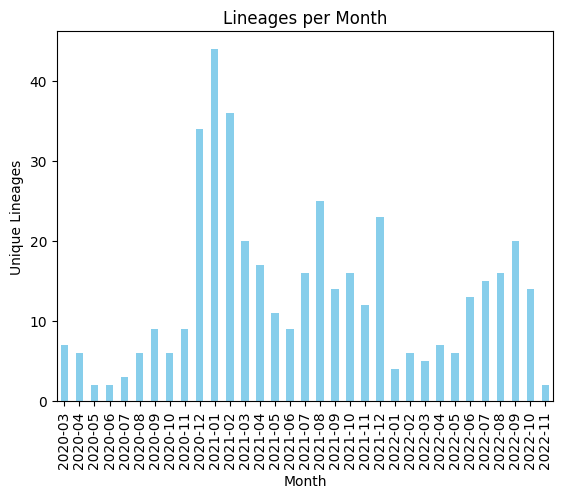

In [7]:
# Parse collection date to datetime format
all_ORFs_SAAP['Collection date'] = pd.to_datetime(all_ORFs_SAAP['Collection date'])

# Extract month
all_ORFs_SAAP['month'] = all_ORFs_SAAP['Collection date'].dt.to_period('M')

# Compute number of unique lineages per month
lineages_per_month = all_ORFs_SAAP.groupby('month')['Nextclade_pango'].nunique()

# Plot number of lineages per month
lineages_per_month.plot(kind='bar', color='skyblue')
plt.xlabel('Month')
plt.ylabel('Unique Lineages')
plt.title('Lineages per Month')
plt.savefig("Lineage_distribution.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Non-synonymous mutation distribution across viruses (non-temporal)

<ipython-input-8-4c62734be8d5>:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  SAAP_profile_2['sum'] = SAAP_profile_2.iloc[:, 2:].sum(axis=1)
<ipython-input-8-4c62734be8d5>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SAAP_profile_2['sum'] = SAAP_profile_2.iloc[:, 2:].sum(axis=1)
<ipython-input-8-4c62734be8d5>:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Delta_2['sum'] = Delta_2.iloc[:, 2:].sum(axis=1

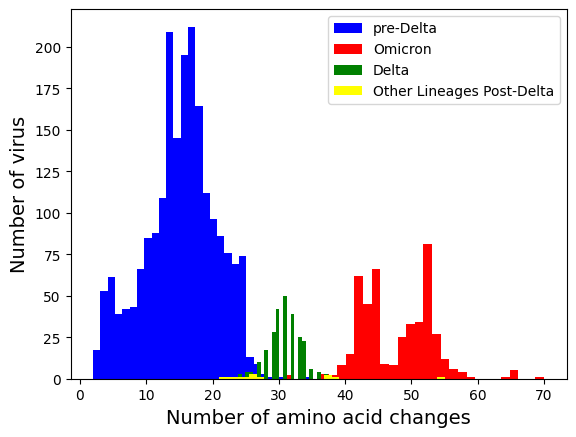

                 sum_sq      df            F  PR(>F)
C(Group)  415000.448684     3.0  5117.246396     0.0
Residual   75394.470758  2789.0          NaN     NaN
ANOVA p-value: 0.0
                    Multiple Comparison of Means - Tukey HSD, FWER=0.05                     
          group1                    group2          meandiff p-adj   lower    upper   reject
--------------------------------------------------------------------------------------------
                    Delta                   Omicron  16.8838    0.0  15.8439  17.9237   True
                    Delta Other Lineages Post-Delta  -0.3851 0.9945   -4.331   3.5609  False
                    Delta                 pre-Delta -15.6493    0.0 -16.5272 -14.7714   True
                  Omicron Other Lineages Post-Delta -17.2689    0.0 -21.1782 -13.3596   True
                  Omicron                 pre-Delta -32.5331    0.0 -33.2283  -31.838   True
Other Lineages Post-Delta                 pre-Delta -15.2643    0.0 -19.1336 -

In [8]:
SAAP_profile = all_ORFs_SAAP
end_date2 = '2021-06-14'
mask2 = (SAAP_profile["Collection date"] <= end_date2)
SAAP_profile_2 = SAAP_profile.loc[mask2]

#Meta.reset_index(inplace=True)
SAAP_profile = SAAP_profile.sort_values(by=['Collection date'])
Delta_2 = SAAP_profile[SAAP_profile['VOC'].str.contains('Delta')]
Omi = SAAP_profile[SAAP_profile['VOC'].str.contains('Omicron')]


start_date3 = '2021-06-15'
mask3 = (SAAP_profile["Collection date"] > start_date3)
SAAP_profile_3 = SAAP_profile.loc[mask3]
nOmi = SAAP_profile_3[~SAAP_profile_3['VOC'].str.contains('Delta')]
OtherV = nOmi[~nOmi['VOC'].str.contains('Omicron')]

SAAP_profile_2['sum'] = SAAP_profile_2.iloc[:, 2:].sum(axis=1)
Delta_2['sum'] = Delta_2.iloc[:, 2:].sum(axis=1)
Omi['sum'] = Omi.iloc[:, 2:].sum(axis=1)
OtherV['sum'] = OtherV.iloc[:, 2:].sum(axis=1)

ax1 = plt.hist(SAAP_profile_2['sum'], color = 'blue', label = 'pre-Delta', bins = 30)
ax3 = plt.hist(Omi['sum'], color = 'red', label = 'Omicron', bins = 30)
ax2 =  plt.hist(Delta_2['sum'], color = 'green', label = 'Delta', bins = 30)
ax4 =  plt.hist(OtherV['sum'], color = 'yellow', label = 'Other Lineages Post-Delta', bins = 30)
plt.ylabel("Number of virus",color="black",fontsize=14)
plt.xlabel("Number of amino acid changes",color="black",fontsize=14)
plt.legend()
plt.savefig("saap_hist.pdf", format="pdf", bbox_inches="tight")
plt.show()



import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import MultiComparison

# Combine data into a single DataFrame
data = pd.DataFrame({
    'Sum': np.concatenate([SAAP_profile_2['sum'], Delta_2['sum'], Omi['sum'], OtherV['sum']]),
    'Group': ['pre-Delta'] * len(SAAP_profile_2) + ['Delta'] * len(Delta_2) + ['Omicron'] * len(Omi) + ['Other Lineages Post-Delta'] * len(OtherV)
})

# Fit ANOVA model
model = ols('Sum ~ C(Group)', data=data).fit()

# Perform ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)
print("ANOVA p-value:", anova_table['PR(>F)']['C(Group)'])
# Perform Tukey's HSD post-hoc test
mc = MultiComparison(data['Sum'], data['Group'])
tukey_result = mc.tukeyhsd()
print(tukey_result)

In [22]:
total_SAAP_profile = SAAP_profile.loc[:, (SAAP_profile != 0).any()]
Omicron_SAAP_profile = SAAP_profile[SAAP_profile['VOC'] == 'Omicron' ]
Omicron_SAAP_profile = Omicron_SAAP_profile.loc[:, (Omicron_SAAP_profile != 0).any()]
Iota_SAAP_profile = SAAP_profile[SAAP_profile['VOC'] == 'Iota']
Iota_SAAP_profile  = Iota_SAAP_profile .loc[:, (Iota_SAAP_profile  != 0).any()]
Alpha_SAAP_profile = SAAP_profile[SAAP_profile['VOC'] == 'Alpha']
Alpha_SAAP_profile = Alpha_SAAP_profile.loc[:, (Alpha_SAAP_profile != 0).any()]
Delta_SAAP_profile = SAAP_profile[SAAP_profile['VOC'] == 'Delta']
Delta_SAAP_profile = Delta_SAAP_profile.loc[:, (Delta_SAAP_profile != 0).any()]

#  Drug resistance markers

In [38]:
import re
import pandas as pd
Drug_resistance = pd.read_csv('Drug_res_alleles_2022-08-11.csv')

Drug_resistance["Amino acid replacement (polyprotein)"] = [re.sub('[^0-9]','', i) for i in Drug_resistance["Amino acid replacement (polyprotein)"]]
DR_position = Drug_resistance[['Gene',"Amino acid replacement (polyprotein)", 'Drug']]

Position_DR = []
for x, y in zip(Drug_resistance['Gene'], Drug_resistance["Amino acid replacement (polyprotein)"]):
    if "S" in x :
        Position_DR.append(f'{y}.1')
    else:
        Position_DR.append(f'{y}')
DR_position['DRPos'] = Position_DR
SAAP_profile = pd.read_csv('all_ORFs_SAAP.csv')
filtered_AA = SAAP_profile.filter(DR_position.DRPos)
filtered_AA = filtered_AA.loc[:, (filtered_AA != 0).any(axis=0)]

Bronx_DR = DR_position[DR_position['DRPos'].isin(filtered_AA.columns)]

Bronx_DR = Bronx_DR.drop_duplicates()

print(Bronx_DR)


<ipython-input-38-40c97a141bb3>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DR_position['DRPos'] = Position_DR


      Gene Amino acid replacement (polyprotein)          Drug  DRPos
0        S                                  486     Ensovibep  486.1
1   ORF1ab                                 3278  Nirmatrelvir   3278
9   orf1ab                                 5191    Remdesivir   5191
11  ORF1ab                                 5191    Remdesivir   5191
27  ORF1ab                                 3452  Nirmatrelvir   3452


# Antibody escape profiles

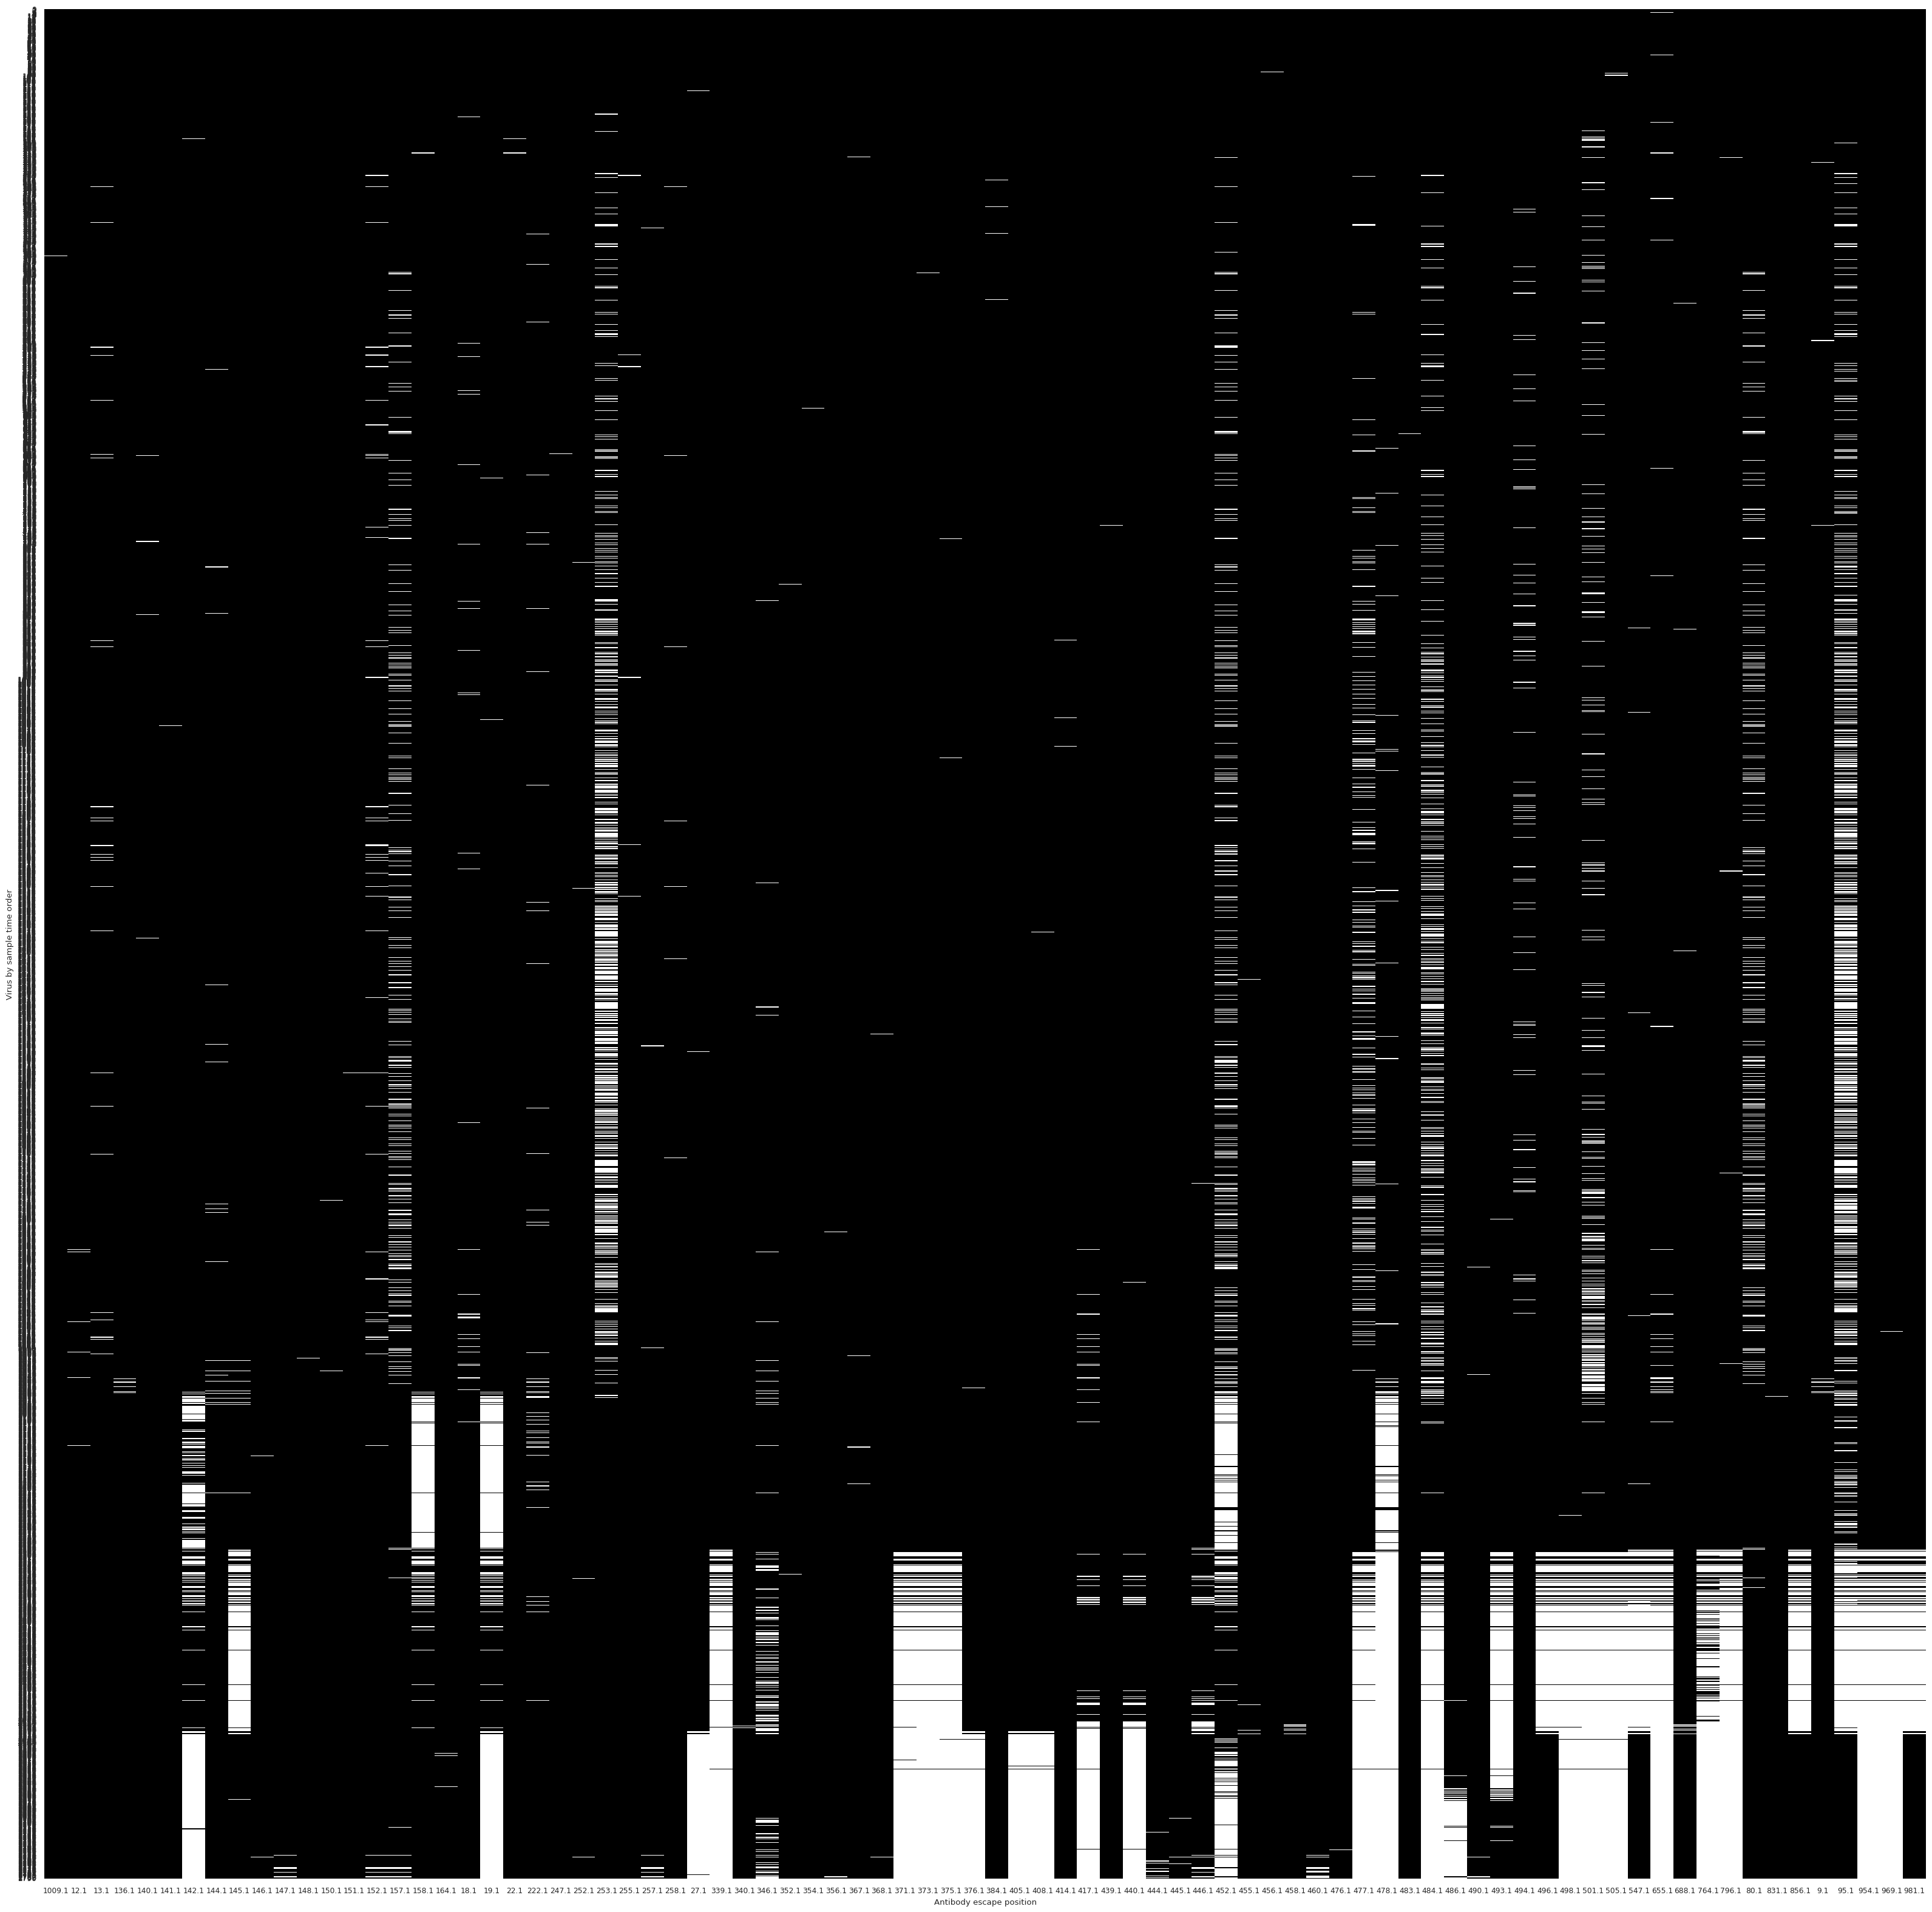

(2791, 82)


In [84]:
import seaborn as sns
import matplotlib.pyplot as plt
# load antibody escape data
Antibody_escape_data = pd.read_csv('Escape_mutations_2022-08-11.csv')

# remove letters from positions
Antibody_escape_data['Amino acid replacement'] = [re.sub('[^0-9]','', i) for i in Antibody_escape_data['Amino acid replacement']]
# create list of escaped antibody positions
ABE_position = pd.DataFrame(Antibody_escape_data['Amino acid replacement'])
ABE_position = ABE_position.drop_duplicates()
ABEpos = []

for x in Antibody_escape_data['Amino acid replacement']:
    ABEpos.append(f'{x}.1')
Antibody_escape_data['ABEpos'] = ABEpos
# load profile of amino acid changes
SAAP_profile = pd.read_csv('all_ORFs_SAAP.csv')
SAAP_profile = SAAP_profile.sort_values('Collection date')
SAAP_profile = SAAP_profile.reset_index()

# filter intersection of dataset and Bronx amino acid changes
#Antibody_escape_data = Antibody_escape_data[Antibody_escape_data['Confidence'] == 'high']
filtered_AA = SAAP_profile.filter(Antibody_escape_data.ABEpos.drop_duplicates())
filtered_AA = filtered_AA.fillna(0, inplace=False)
filtered_AA = filtered_AA.loc[:, (filtered_AA.sum() != 0)]
filtered_AA = filtered_AA.loc[:, (filtered_AA != 0).any()]
filtered_AA = filtered_AA.sort_index(axis=1, inplace=False)

# make raw plot for Antibody Escape Genotype
sns.set(font_scale=0.8)
plt.figure(figsize=(40, 40))
ax = sns.heatmap(filtered_AA, cmap='gray', yticklabels = True, xticklabels = True, cbar=False, vmin=0, vmax=1)
plt.ylabel('Virus by sample time order')
plt.xlabel('Antibody escape position')
plt.savefig("AbsEsc_map.pdf", format="pdf", bbox_inches="tight")
plt.show()
print(filtered_AA.shape)


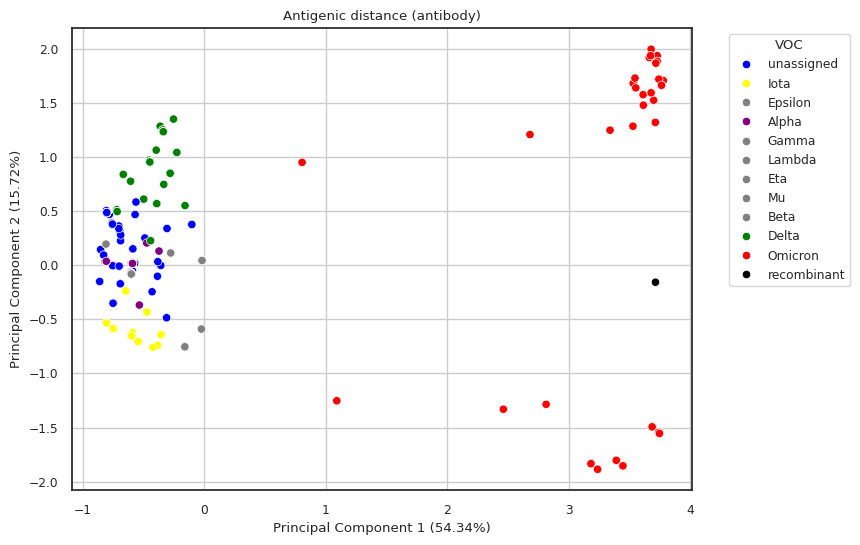

In [79]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style='white')
# Perform PCA
pca = PCA()
pca.fit(filtered_AA)

# Transform the data
pca_data = pca.transform(filtered_AA)

# Extract categories based on row index
categories = SAAP_profile["VOC"]
color_mapping = {'unassigned': 'blue', 'Iota': 'yellow', 'Alpha': 'purple',
                 'Delta':'green', 'Omicron':'red','Epsilon':'grey',
                 'Lambda':'grey', 'Gamma':'grey', 'Eta':'grey', 'Mu':'grey',
                 'Beta':'grey', 'recombinant':'black',
}


# Percentage of variance explained by each principal component
explained_variance_ratio = pca.explained_variance_ratio_

# Visualize PCA results along with the percentage of variance explained
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=categories.values.flatten(), palette=color_mapping)
plt.xlabel('Principal Component 1 ({}%)'.format(round(explained_variance_ratio[0] * 100, 2)))
plt.ylabel('Principal Component 2 ({}%)'.format(round(explained_variance_ratio[1] * 100, 2)))
plt.title('Antigenic distance (antibody)')
plt.grid(True)
legend = plt.legend(title='VOC')
legend.set_bbox_to_anchor((1.05, 1))
plt.savefig("AbsEsc_dist_PCA.pdf", format="pdf", bbox_inches="tight")
plt.show()

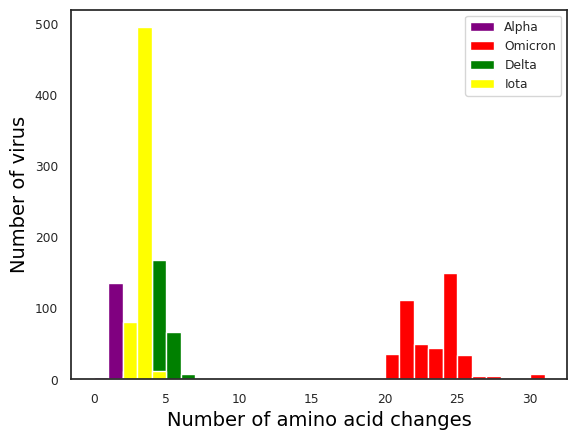

In [80]:
SAAP_profile.sort_values(by=["Collection date"])
#print(SAAP_profile)
filtered_AA.index = SAAP_profile["VOC"]
#print(aggregated_matrix)
Omicron_ab = filtered_AA[filtered_AA.index == 'Omicron']
Omicron_ab = Omicron_ab.loc[:, (Omicron_ab != 0).any()]
Delta_ab = filtered_AA[filtered_AA.index == 'Delta']
Delta_ab= Delta_ab.loc[:, (Delta_ab != 0).any()]
Iota_ab = filtered_AA[filtered_AA.index == 'Iota']
Iota_ab = Iota_ab.loc[:, (Iota_ab != 0).any()]
Alpha_ab = filtered_AA[filtered_AA.index == 'Alpha']
Alpha_ab = Alpha_ab.loc[:, (Alpha_ab != 0).any()]


Omicron_ab['sum'] = Omicron_ab.iloc[:, 2:].sum(axis=1)
Delta_ab['sum'] = Delta_ab.iloc[:, 2:].sum(axis=1)
Alpha_ab['sum'] = Alpha_ab.iloc[:, 2:].sum(axis=1)
Iota_ab['sum'] = Iota_ab.iloc[:, 2:].sum(axis=1)

# Specify common bin edges
bin_edges = range(min(min(Alpha_ab['sum']), min(Omicron_ab['sum']), min(Delta_ab['sum']), min(Iota_ab['sum'])),
                  max(max(Alpha_ab['sum']), max(Omicron_ab['sum']), max(Delta_ab['sum']), max(Iota_ab['sum'])) + 1)

plt.hist(Alpha_ab['sum'], color='purple', label='Alpha', bins=bin_edges, alpha=1)
plt.hist(Omicron_ab['sum'], color='red', label='Omicron', bins=bin_edges, alpha=1)
plt.hist(Delta_ab['sum'], color='green', label='Delta', bins=bin_edges, alpha=1)
plt.hist(Iota_ab['sum'], color='yellow', label='Iota', bins=bin_edges, alpha=1)

plt.ylabel("Number of virus",color="black",fontsize=14)
plt.xlabel("Number of amino acid changes",color="black",fontsize=14)
plt.legend()
plt.savefig("saap_ab_hist.pdf", format="pdf", bbox_inches="tight")
plt.show()

import statsmodels.api as sm

count_data = pd.DataFrame({
    'Counts': list(Alpha_ab['sum']) + list(Iota_ab['sum']) + list(Delta_ab['sum']) + list(Omicron_ab['sum']),
    'Group': ['Alpha'] * len(Alpha_ab['sum']) + ['Iota'] * len(Iota_ab['sum']) + ['Delta'] * len(Delta_ab['sum']) + ['Omicron'] * len(Omicron_ab['sum'])
})

<ipython-input-81-8d3d3f107358>:5: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.7`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.

  sns.kdeplot(data=count_data, x='Counts', hue='Group', bw=0.7 ,fill=True, palette=['purple', 'yellow', 'green', 'red'], alpha=0.5, linewidth=0, ax=ax)


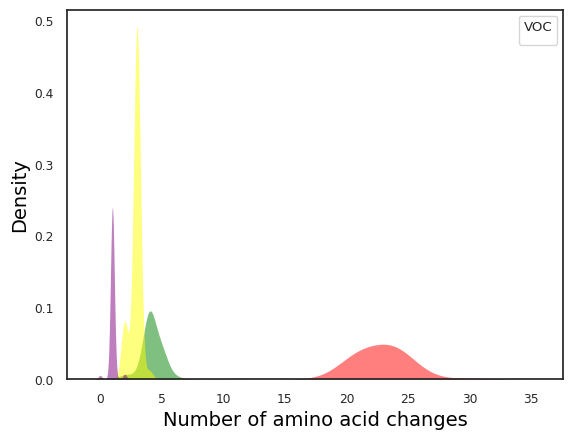

In [81]:
# Create a figure and axis objects
fig, ax = plt.subplots()

# Plot density plots
sns.kdeplot(data=count_data, x='Counts', hue='Group', bw=0.7 ,fill=True, palette=['purple', 'yellow', 'green', 'red'], alpha=0.5, linewidth=0, ax=ax)

# Set labels and legend
ax.set_xlabel("Number of amino acid changes", color="black", fontsize=14)
ax.set_ylabel("Density", color="black", fontsize=14)
ax.legend(title='VOC')

# Save or show the plot
plt.savefig("saap_ab_density_plots.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [85]:
SAAP_profile_sorted = SAAP_profile.sort_values(by=["Collection date"])

filtered_AA['sum'] = filtered_AA.iloc[:, 2:].sum(axis=1)
filtered_AA['Collection_date'] = SAAP_profile_sorted["Collection date"]
filtered_AA["VOC"] = SAAP_profile_sorted["VOC"]

voc = ['Omicron', 'Delta', 'Iota', 'Alpha']

virus_data = filtered_AA[filtered_AA.VOC.isin(voc)]
virus_data = virus_data[["Collection_date","VOC","sum"]]


print(virus_data)

     Collection_date      VOC  sum
244       2020-12-03     Iota    2
245       2020-12-04     Iota    2
251       2020-12-09     Iota    2
273       2020-12-16     Iota    3
296       2020-12-19     Iota    2
...              ...      ...  ...
2786      2022-10-18  Omicron   27
2787      2022-10-18  Omicron   32
2788      2022-10-18  Omicron   32
2789      2022-11-07  Omicron   28
2790      2022-11-14  Omicron   26

[1442 rows x 3 columns]


In [86]:
import statsmodels.api as sm

virus_data['Collection_date'] = pd.to_datetime(virus_data['Collection_date'])

# Encoding categorical variable 'VOC' into dummy variables
virus_data_dummy = pd.get_dummies(virus_data, columns=['VOC'], drop_first=False)

# Calculate the number of days elapsed since the earliest collection date
start_date = virus_data_dummy['Collection_date'].min()
virus_data_dummy['Days_elapsed'] = (virus_data_dummy['Collection_date'] - start_date).dt.days


# Creating interaction terms for each virus and time
virus_data_dummy['VOC_Alpha:time'] = virus_data_dummy['VOC_Alpha'] * virus_data_dummy['Days_elapsed']
virus_data_dummy['VOC_Iota:time'] = virus_data_dummy['VOC_Iota'] * virus_data_dummy['Days_elapsed']
virus_data_dummy['VOC_Delta:time'] = virus_data_dummy['VOC_Delta'] * virus_data_dummy['Days_elapsed']
virus_data_dummy['VOC_Omicron:time'] = virus_data_dummy['VOC_Omicron'] * virus_data_dummy['Days_elapsed']

# Define the independent variables X and the dependent variable y
X = virus_data_dummy[['VOC_Alpha', 'VOC_Iota', 'VOC_Delta', 'VOC_Omicron',
                      'VOC_Alpha:time', 'VOC_Iota:time', 'VOC_Delta:time', 'VOC_Omicron:time']]

y = virus_data_dummy['sum']

# Add a constant to the independent variables (OLS regression intercept)
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Print the summary of the regression results
print(model.summary())

print("\nTesting if coefficients of Alpha and Iota are equal:")
print("F-test p-value:", model.f_test("VOC_Alpha = VOC_Iota"))

print("\nTesting if coefficients of Alpha and Delta are equal:")
print("F-test p-value:", model.f_test("VOC_Alpha = VOC_Delta"))

print("\nTesting if coefficients of Alpha and Omicron are equal:")
print("F-test p-value:", model.f_test("VOC_Alpha = VOC_Omicron"))

print("\nTesting if coefficients of Delta and Iota are equal:")
print("F-test p-value:", model.f_test("VOC_Delta = VOC_Iota"))

print("\nTesting if coefficients of Delta and Omicron are equal:")
print("F-test p-value:", model.f_test("VOC_Delta = VOC_Omicron"))

print("\nTesting if coefficients of Iota and Omicron are equal:")
print("F-test p-value:", model.f_test("VOC_Iota = VOC_Omicron"))


                            OLS Regression Results                            
Dep. Variable:                    sum   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                 1.626e+04
Date:                Fri, 01 Mar 2024   Prob (F-statistic):               0.00
Time:                        00:06:47   Log-Likelihood:                -2159.4
No. Observations:                1442   AIC:                             4335.
Df Residuals:                    1434   BIC:                             4377.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                4.9670      0.116  

# Antibodies impacted

(2791, 48)


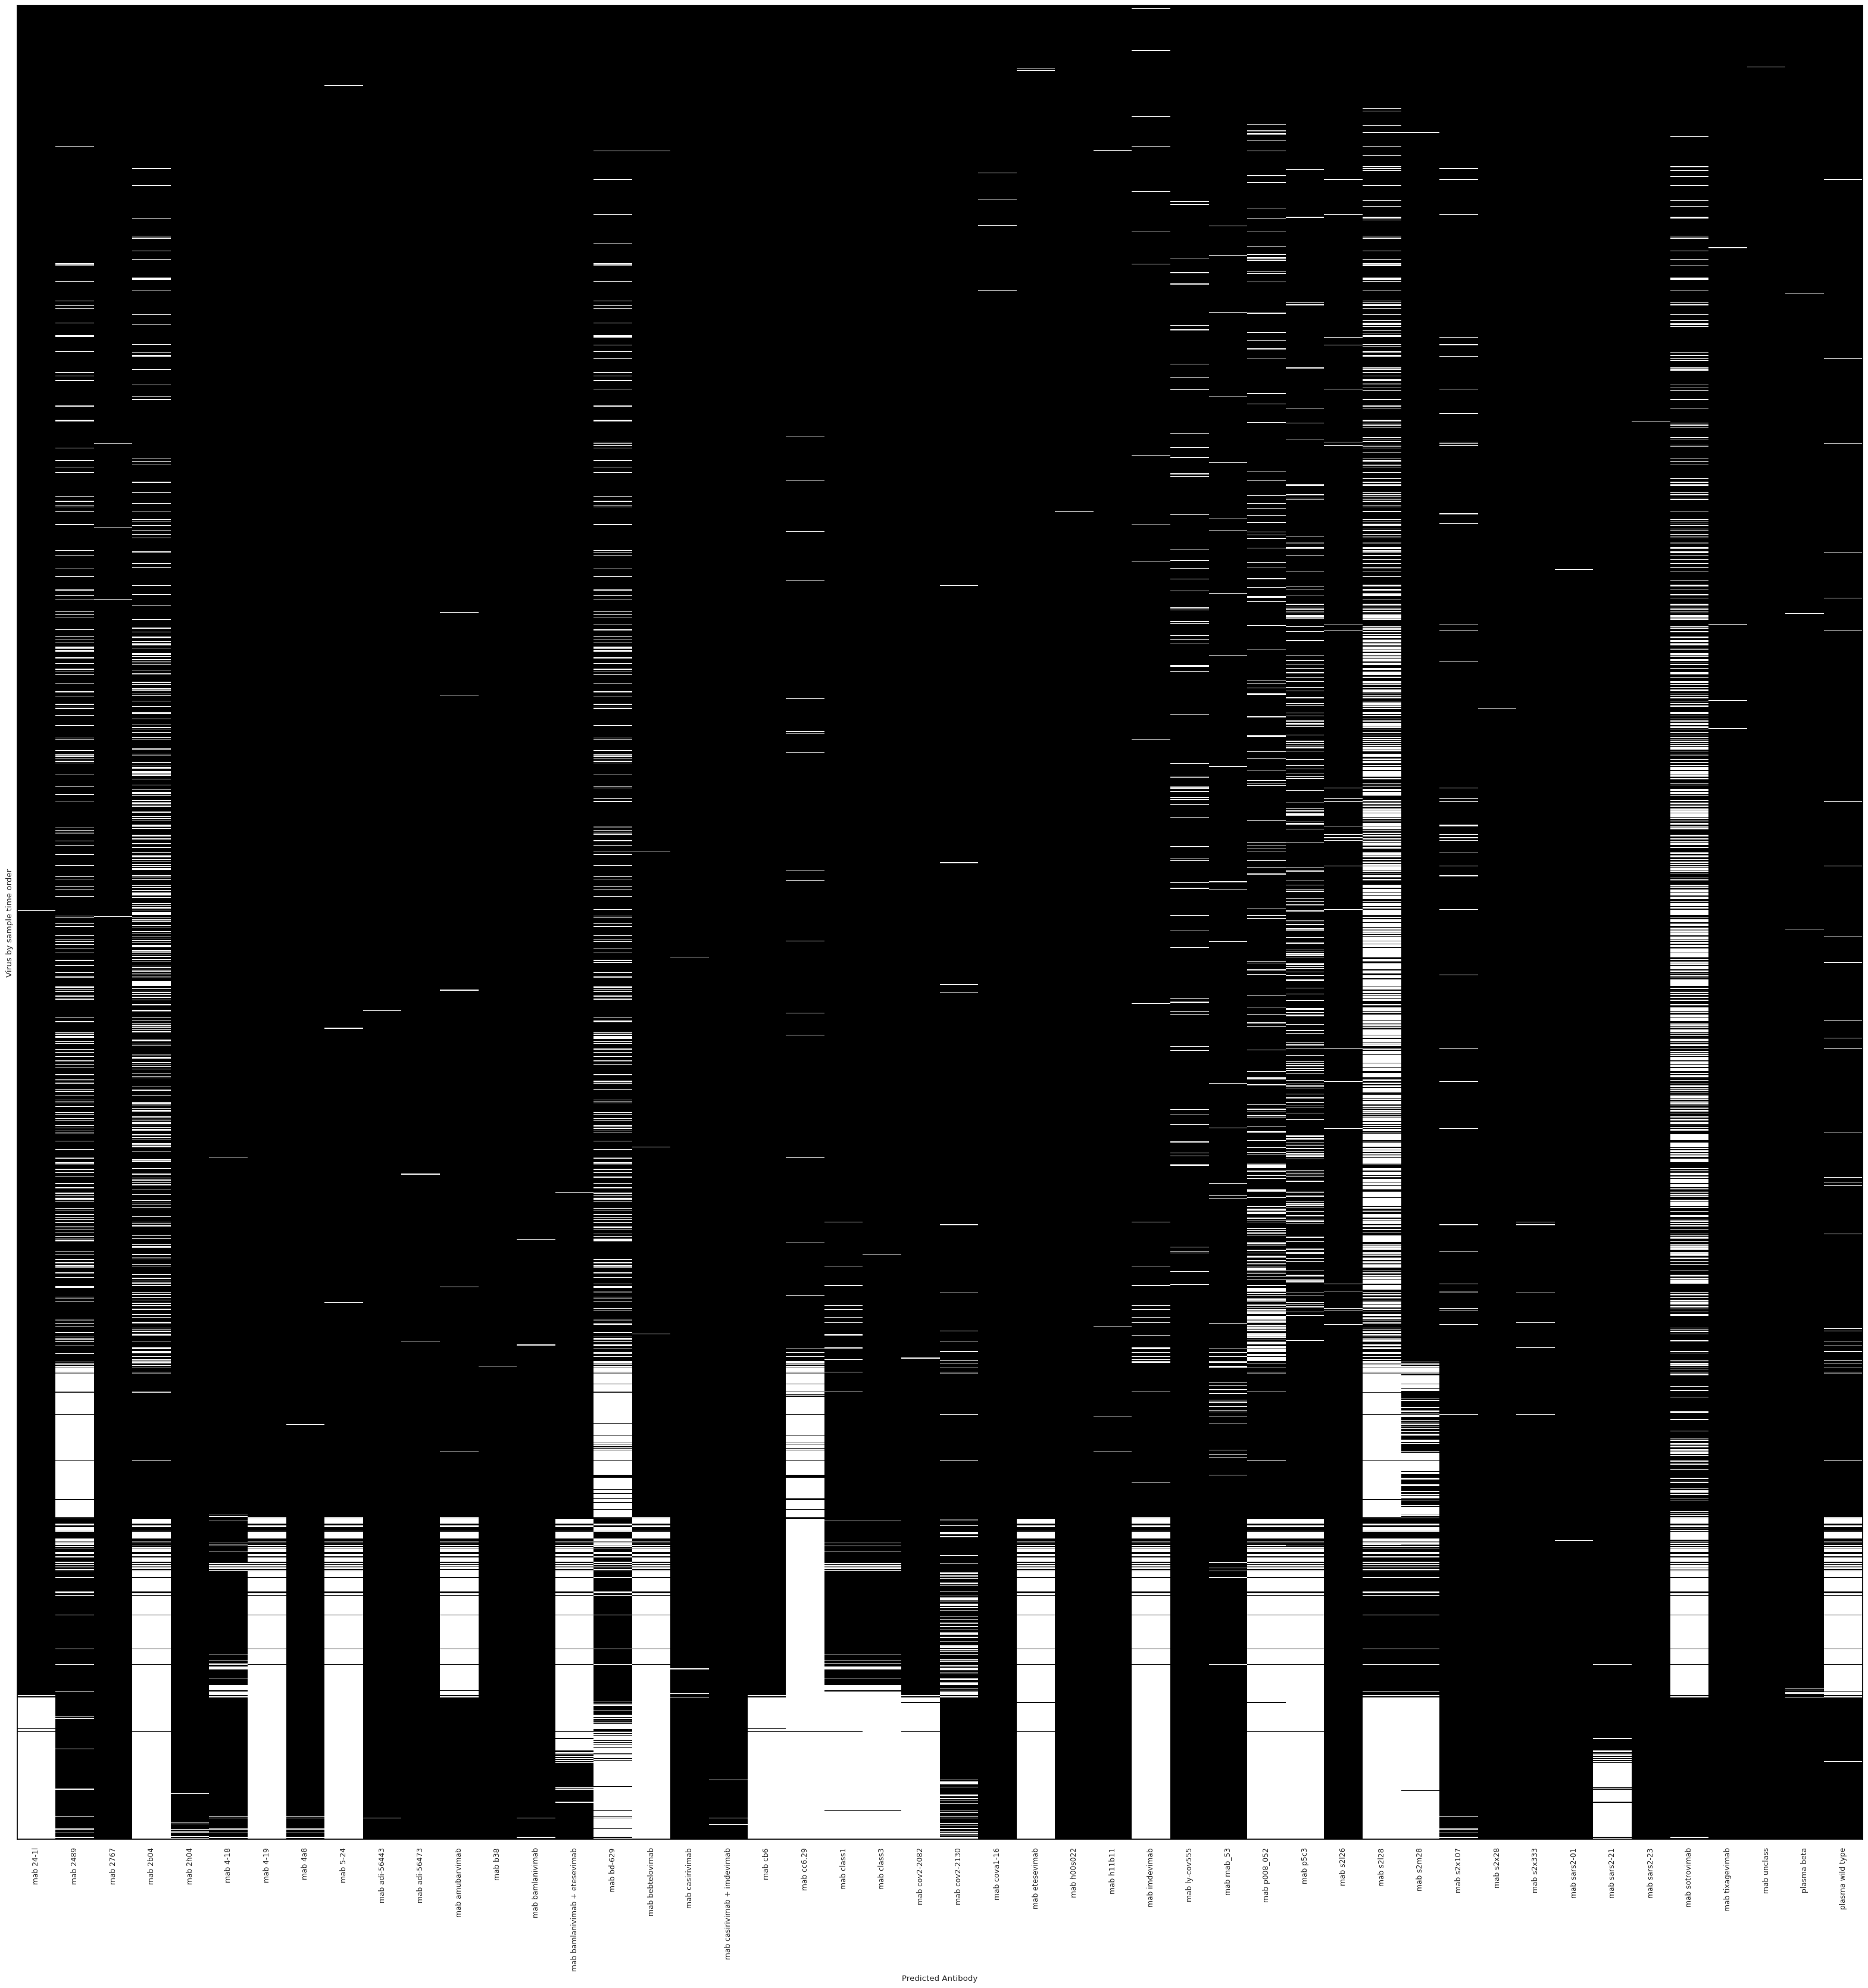

In [87]:
import pandas as pd

# load antibody escape data
Antibody_escape_data = pd.read_csv('Escape_mutations_2022-08-11.csv')
# remove letters from positions
Antibody_escape_data['Amino acid replacement'] = [re.sub('[^0-9]','', i) for i in Antibody_escape_data['Amino acid replacement']]
# create list of escaped antibody positions
ABE_position = pd.DataFrame(Antibody_escape_data['Amino acid replacement'])
ABE_position = ABE_position.drop_duplicates()
ABEpos = []

for x in Antibody_escape_data['Amino acid replacement']:
    ABEpos.append(f'{x}.1')
Antibody_escape_data['ABEpos'] = ABEpos


Antibody_escape_data['Escape mutations details'] = Antibody_escape_data['Escape mutations details'].apply(lambda x: x.split(", "))
exploded_df = Antibody_escape_data.explode('Escape mutations details')

unique_pairs = list(set(zip(exploded_df['ABEpos'], exploded_df['Escape mutations details'])))
Escaped_mAB = dict(unique_pairs)
Escaped_mAB = {key: value.lower() for key, value in Escaped_mAB.items()}

aggregated_matrix = filtered_AA.groupby(Escaped_mAB, axis=1).sum()
aggregated_matrix[aggregated_matrix > 0] = 1
# Print the aggregated matrix
print(aggregated_matrix.shape)

plt.figure(figsize=(40, 40))
ax = sns.heatmap(aggregated_matrix, cmap="gray", yticklabels = False, xticklabels = True, cbar=False)

# Add a border to the plot
ax.spines['top'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')


plt.ylabel('Virus by sample time order')
plt.xlabel('Predicted Antibody')
plt.savefig("AbsEsc_map.pdf", format="pdf", bbox_inches="tight")
plt.show()


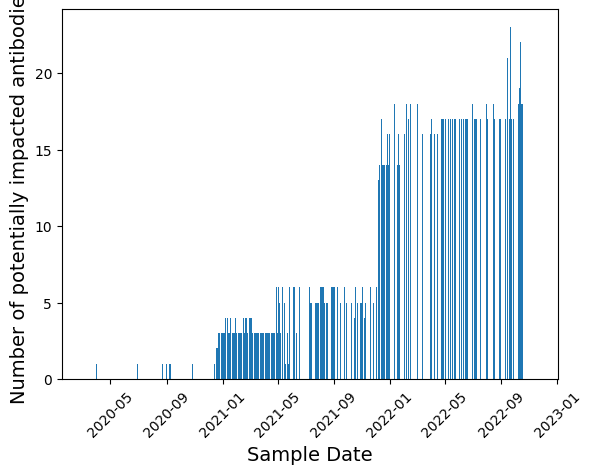

In [ ]:
# aggegrate data for time series plot
aggregated_matrix['ABsum'] = aggregated_matrix.sum(axis=1)
aggregated_matrix['Collection date'] = pd.to_datetime(SAAP_profile['Collection date'])
aggregated_matrix.set_index('Collection date', inplace=True)
sns.reset_orig()

plt.bar(aggregated_matrix.index, aggregated_matrix['ABsum'])
plt.ylabel("Number of potentially impacted antibodies", color="black", fontsize=14)
plt.xlabel("Sample Date",color="black",fontsize=14)
plt.xticks(rotation = 45)
plt.savefig("ABTS.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Total T-cell epitope changes

(2791, 1199)


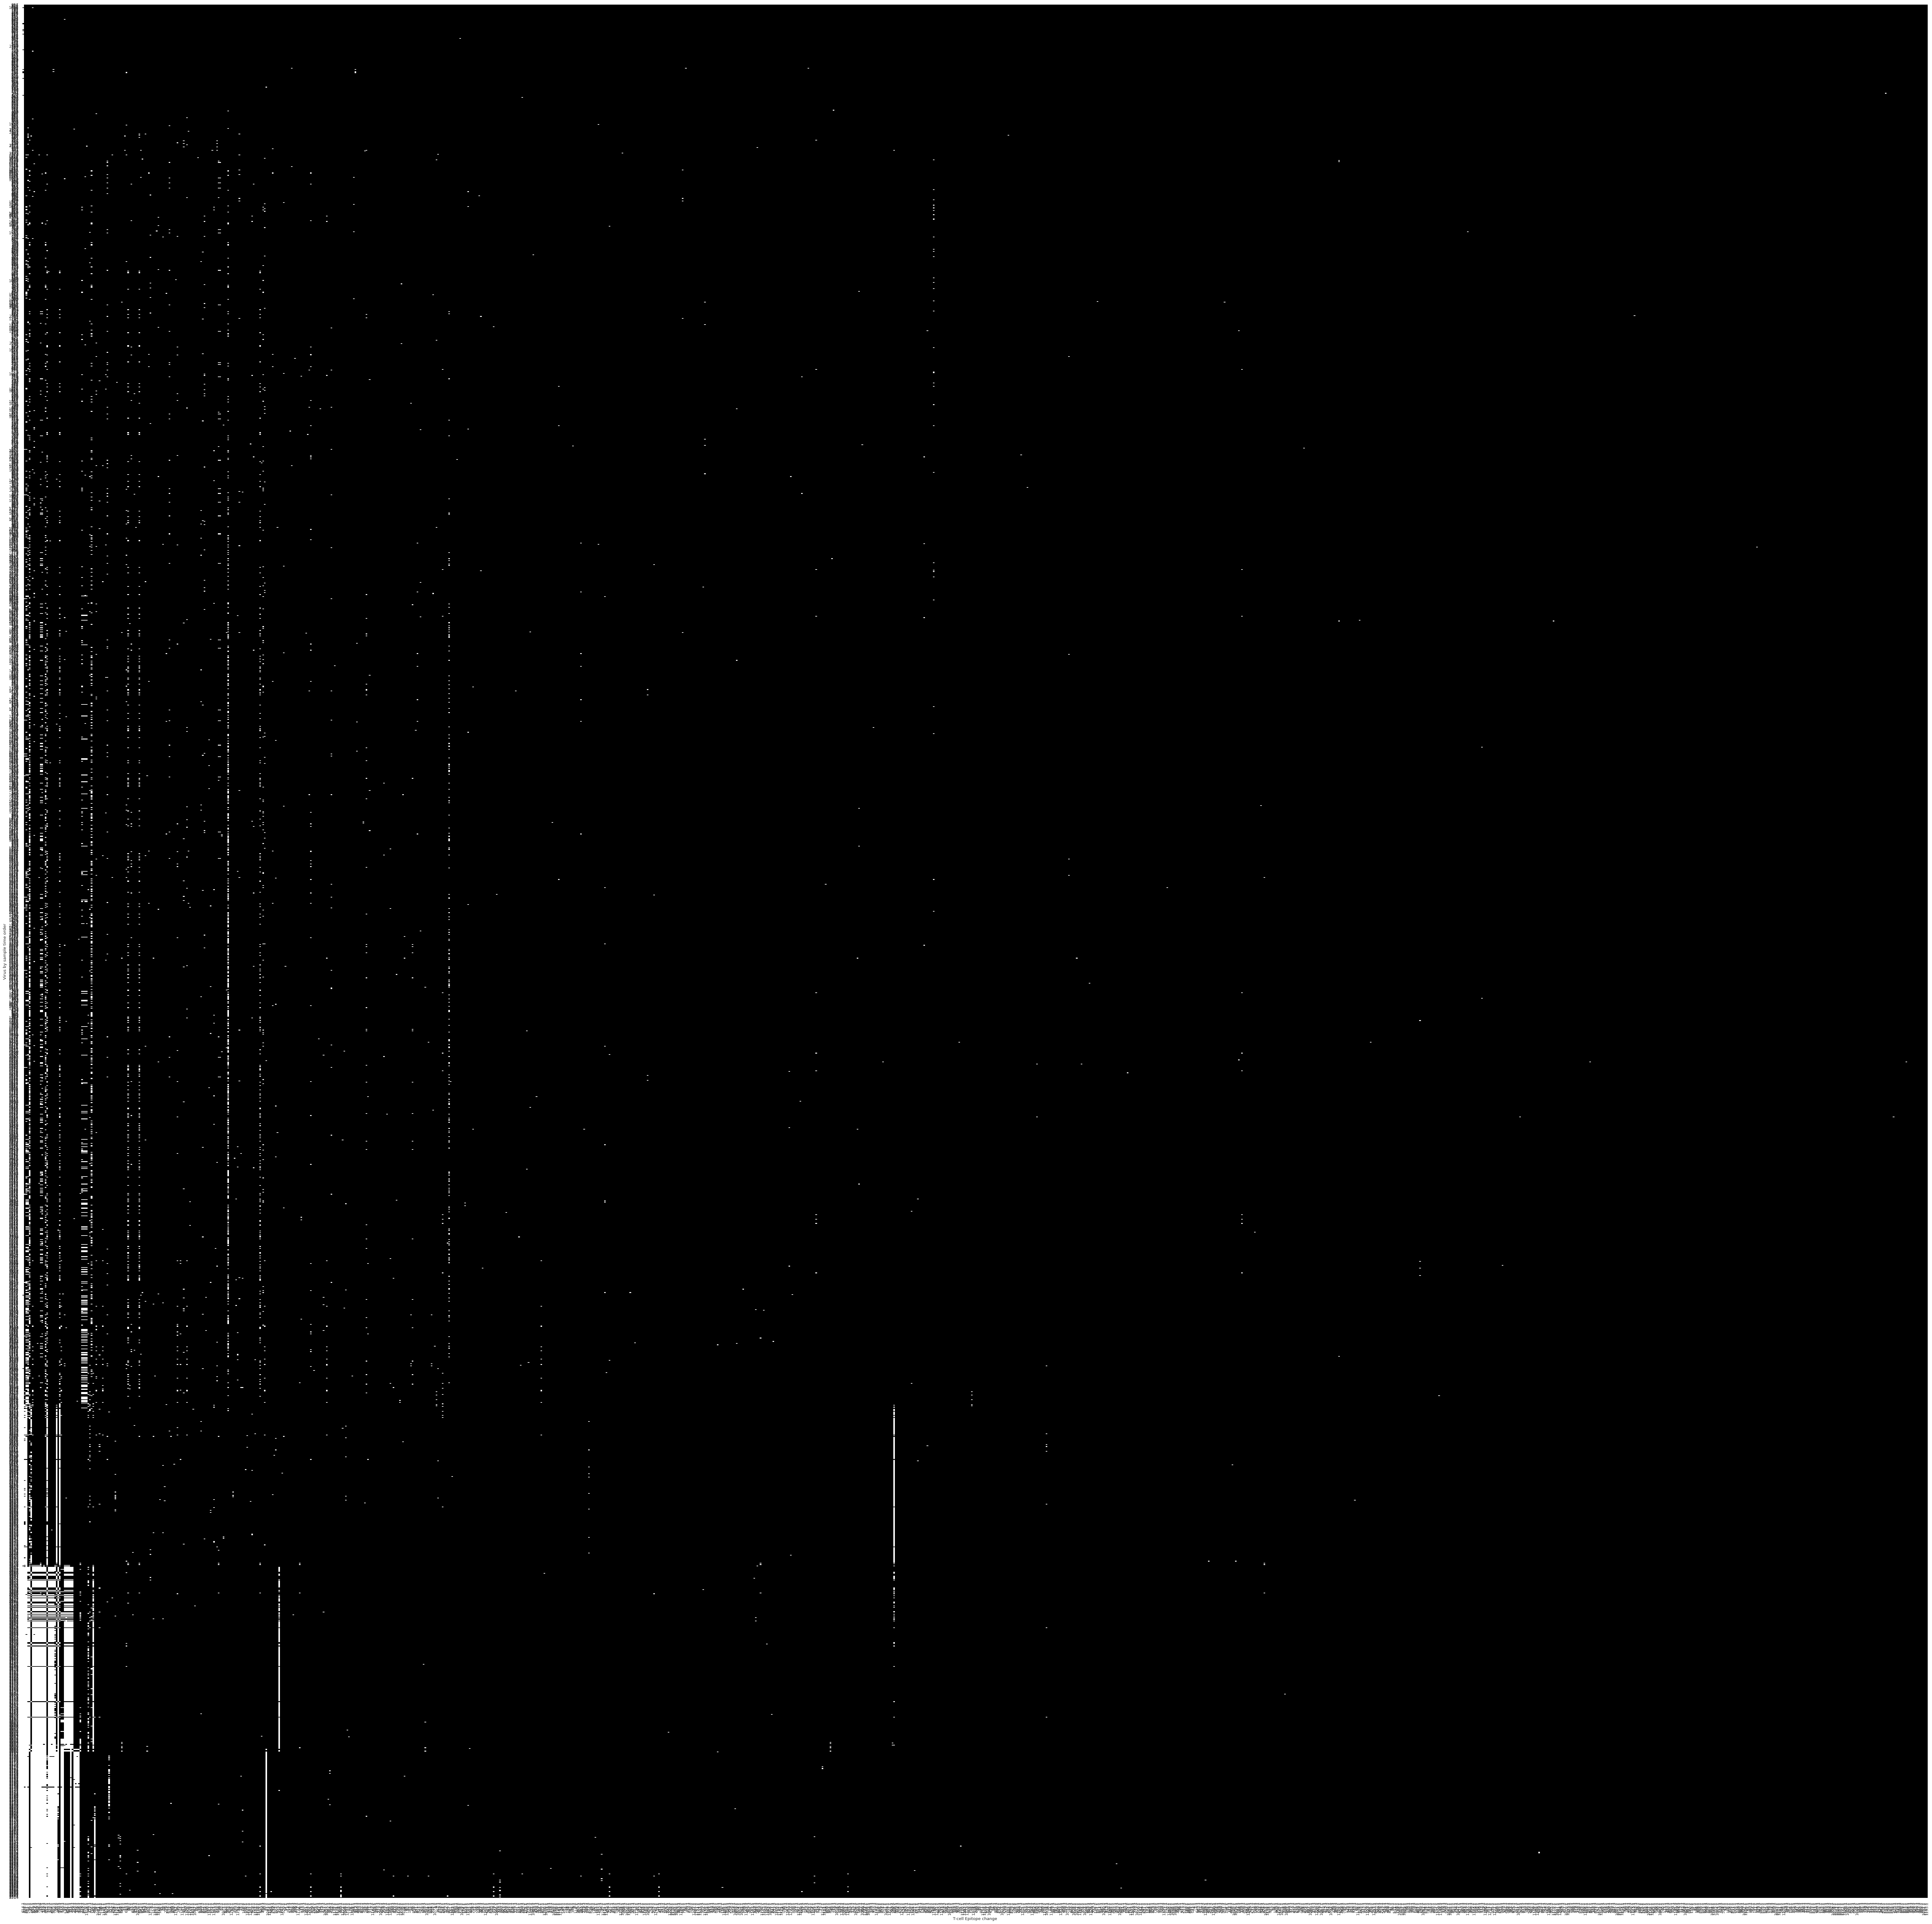

In [56]:
Tcell_data = pd.read_csv('tcell_2022-08-11.csv')

Tcell_data['Amino acid replacement'] = [re.sub('[^0-9]','', i) for i in Tcell_data['Amino acid replacement']]

Epitope_position = Tcell_data[['Gene','Amino acid replacement']]

Position_E = []

Gene = Epitope_position['Gene']

AA = Epitope_position['Amino acid replacement']
for x, y in zip(Gene, AA):
    if "S" in x :
        Position_E.append(f'{y}.1')
    elif "M" in x:
        Position_E.append(f'{y}.3')
    elif "N" in x:
        Position_E.append(f'{y}.9')
    elif "ORF3a" in x:
        Position_E.append(f'{y}.2')

Tcell_data['Epitope_position'] = Position_E

SAAP_profile = pd.read_csv('all_ORFs_SAAP.csv')

SAAP_profile = SAAP_profile.sort_values('Collection date')

filtered_AA = SAAP_profile.filter(Tcell_data.Epitope_position.drop_duplicates())

filtered_AA[filtered_AA > 0] = 1

print(filtered_AA.shape)

plt.figure(figsize=(80, 80))
ax = sns.heatmap(filtered_AA, cmap='gray', yticklabels = True, xticklabels = True, cbar=False, vmin=0, vmax=1)
plt.ylabel('Virus by sample time order')
plt.xlabel('T-cell Epitope change')
plt.savefig("T-cell_Epitope_change.pdf", format="pdf", bbox_inches="tight")
plt.show()


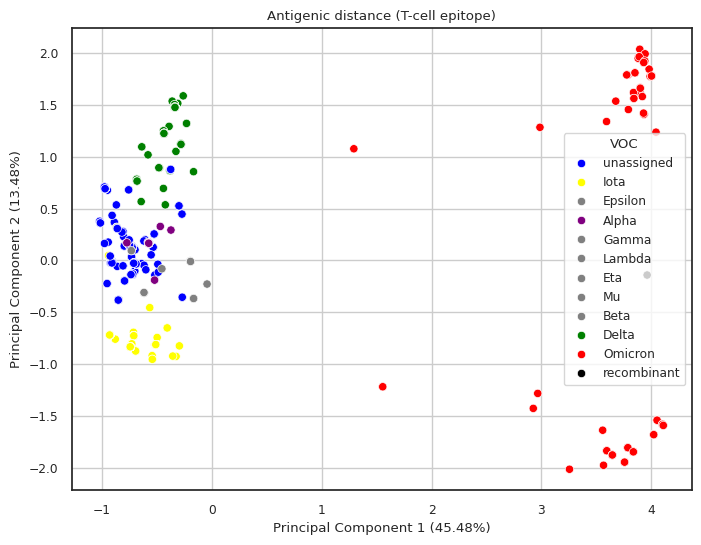

In [57]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Perform PCA
pca = PCA()
pca.fit(filtered_AA)

# Transform the data
pca_data = pca.transform(filtered_AA)

# Extract categories based on row index
categories = SAAP_profile["VOC"]
color_mapping = {'unassigned': 'blue', 'Iota': 'yellow', 'Alpha': 'purple',
                 'Delta':'green', 'Omicron':'red','Epsilon':'grey',
                 'Lambda':'grey', 'Gamma':'grey', 'Eta':'grey', 'Mu':'grey',
                 'Beta':'grey', 'recombinant':'black',
}

# Percentage of variance explained by each principal component
explained_variance_ratio = pca.explained_variance_ratio_

# Visualize PCA results along with the percentage of variance explained
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=categories.values.flatten(), palette=color_mapping)
plt.xlabel('Principal Component 1 ({}%)'.format(round(explained_variance_ratio[0] * 100, 2)))
plt.ylabel('Principal Component 2 ({}%)'.format(round(explained_variance_ratio[1] * 100, 2)))
plt.title('Antigenic distance (T-cell epitope)')
plt.grid(True)
plt.legend(title='VOC')
plt.savefig("T_cell_antigen_dist_PCA.pdf", format="pdf", bbox_inches="tight")
plt.show()

<ipython-input-47-b9f0fa0049a2>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Omicron_ab['sum'] = Omicron_ab.iloc[:, 2:].sum(axis=1)


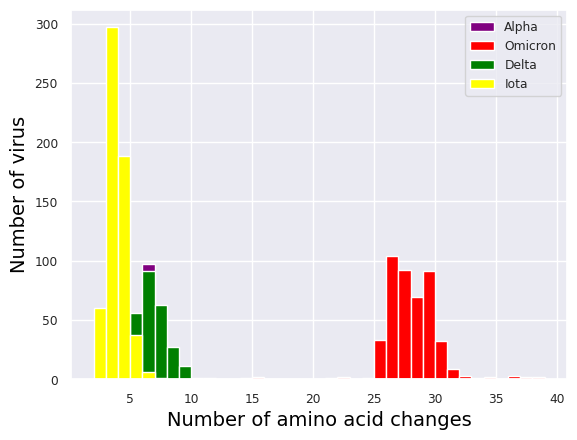

In [47]:
SAAP_profile.sort_values(by=["Collection date"])
#print(SAAP_profile)
filtered_AA.index = SAAP_profile["VOC"]
#print(aggregated_matrix)
Omicron_ab = filtered_AA[filtered_AA.index == 'Omicron']
Omicron_ab = Omicron_ab.loc[:, (Omicron_ab != 0).any()]
Delta_ab = filtered_AA[filtered_AA.index == 'Delta']
Delta_ab= Delta_ab.loc[:, (Delta_ab != 0).any()]
Iota_ab = filtered_AA[filtered_AA.index == 'Iota']
Iota_ab = Iota_ab.loc[:, (Iota_ab != 0).any()]
Alpha_ab = filtered_AA[filtered_AA.index == 'Alpha']
Alpha_ab = Alpha_ab.loc[:, (Alpha_ab != 0).any()]


Omicron_ab['sum'] = Omicron_ab.iloc[:, 2:].sum(axis=1)
Delta_ab['sum'] = Delta_ab.iloc[:, 2:].sum(axis=1)
Alpha_ab['sum'] = Alpha_ab.iloc[:, 2:].sum(axis=1)
Iota_ab['sum'] = Iota_ab.iloc[:, 2:].sum(axis=1)

# Specify common bin edges
bin_edges = range(min(min(Alpha_ab['sum']), min(Omicron_ab['sum']), min(Delta_ab['sum']), min(Iota_ab['sum'])),
                  max(max(Alpha_ab['sum']), max(Omicron_ab['sum']), max(Delta_ab['sum']), max(Iota_ab['sum'])) + 1)

plt.hist(Alpha_ab['sum'], color='purple', label='Alpha', bins=bin_edges, alpha=1)
plt.hist(Omicron_ab['sum'], color='red', label='Omicron', bins=bin_edges, alpha=1)
plt.hist(Delta_ab['sum'], color='green', label='Delta', bins=bin_edges, alpha=1)
plt.hist(Iota_ab['sum'], color='yellow', label='Iota', bins=bin_edges, alpha=1)

plt.ylabel("Number of virus",color="black",fontsize=14)
plt.xlabel("Number of amino acid changes",color="black",fontsize=14)
plt.legend()
plt.savefig("saap_TC_hist.pdf", format="pdf", bbox_inches="tight")
plt.show()

count_data = pd.DataFrame({
    'Counts': list(Alpha_ab['sum']) + list(Iota_ab['sum']) + list(Delta_ab['sum']) + list(Omicron_ab['sum']),
    'Group': ['Alpha'] * len(Alpha_ab['sum']) + ['Iota'] * len(Iota_ab['sum']) + ['Delta'] * len(Delta_ab['sum']) + ['Omicron'] * len(Omicron_ab['sum'])
})


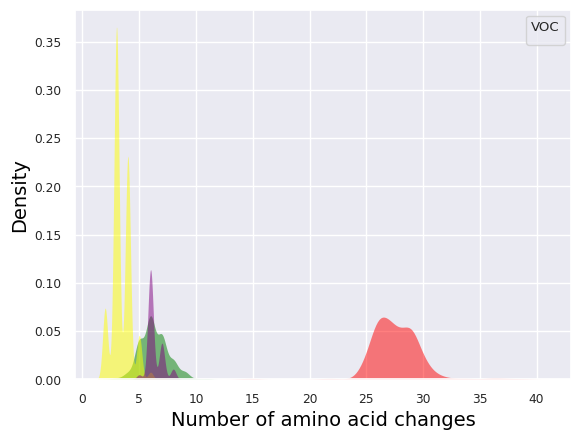

In [48]:
# Create a figure and axis objects
fig, ax = plt.subplots()

# Plot density plots
sns.kdeplot(data=count_data, x='Counts', hue='Group',bw=0.5, fill=True, palette=['purple', 'yellow', 'green', 'red'], alpha=0.5, linewidth=0, ax=ax)

# Set labels and legend
ax.set_xlabel("Number of amino acid changes", color="black", fontsize=14)
ax.set_ylabel("Density", color="black", fontsize=14)
ax.legend(title='VOC')

# Save or show the plot
plt.savefig("saap_TC_density_plots.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [49]:
from scipy.stats import kruskal
from itertools import combinations


max_values = [np.max(group['Counts']) for name, group in count_data.groupby('Group')]


# Perform Kruskal-Wallis test
statistic, p_value = kruskal(*[group['Counts'] for name, group in count_data.groupby('Group')])

# Print the test statistic and p-value
print("Kruskal-Wallis Test:")
print("Statistic:", statistic)
print("p-value:", p_value)

# Perform post-hoc analysis if Kruskal-Wallis test is significant
if p_value < 0.05:
    # Determine pairwise comparisons of maximum values
    pairwise_comparisons = list(combinations(zip(max_values, count_data['Group'].unique()), 2))

    # Print pairwise comparisons
    print("\nPairwise Maximum Value Comparisons:")
    for comparison in pairwise_comparisons:
        print(f"{comparison[0][1]} vs {comparison[1][1]}: {comparison[0][0]} vs {comparison[1][0]}")

Kruskal-Wallis Test:
Statistic: 1263.1192450638612
p-value: 1.479607754179587e-273

Pairwise Maximum Value Comparisons:
Alpha vs Iota: 8 vs 11
Alpha vs Delta: 8 vs 7
Alpha vs Omicron: 8 vs 39
Iota vs Delta: 11 vs 7
Iota vs Omicron: 11 vs 39
Delta vs Omicron: 7 vs 39


In [ ]:
SAAP_profile.sort_values(by=["Collection date"])
#print(SAAP_profile)
filtered_AA.index = SAAP_profile["VOC"]

Omicron_ab = filtered_AA[filtered_AA.index == 'Omicron']
Omicron_ab = Omicron_ab.loc[:, (Omicron_ab != 0).any()]
Delta_ab = filtered_AA[filtered_AA.index == 'Delta']
Delta_ab= Delta_ab.loc[:, (Delta_ab != 0).any()]
Iota_ab = filtered_AA[filtered_AA.index == 'Iota']
Iota_ab = Iota_ab.loc[:, (Iota_ab != 0).any()]
Alpha_ab = filtered_AA[filtered_AA.index == 'Alpha']
Alpha_ab = Alpha_ab.loc[:, (Alpha_ab != 0).any()]

print(Omicron_ab.shape)
print(Delta_ab.shape)
print(Iota_ab.shape)
print(Alpha_ab.shape)


gene = Tcell_data[Tcell_data['Epitope_position'].isin(Alpha_ab.columns)][['Gene', 'Epitope_position']]

len(np.unique(gene[gene['Gene'] == "S"]['Epitope_position']))

(450, 115)
(261, 74)
(589, 78)
(142, 36)


36

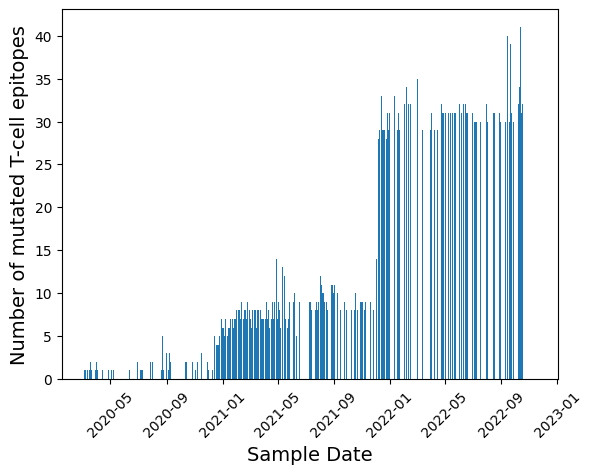

In [ ]:
# aggegrate data for time series plot
filtered_AA['TCsum'] = filtered_AA.sum(axis=1)
filtered_AA['Collection date'] = pd.to_datetime(SAAP_profile['Collection date'])
filtered_AA.set_index('Collection date', inplace=True)

sns.reset_orig()

plt.bar(filtered_AA.index, filtered_AA['TCsum'])
plt.ylabel("Number of mutated T-cell epitopes", color="black", fontsize=14)
plt.xlabel("Sample Date",color="black",fontsize=14)
plt.xticks(rotation = 45)
plt.savefig("TCTS.pdf", format="pdf", bbox_inches="tight")
plt.show()

# CD8 T-cell epitope changes

<ipython-input-66-deb7ec9d0cde>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tcell_data['Epitope_position'] = Position_E


(2791, 1134)


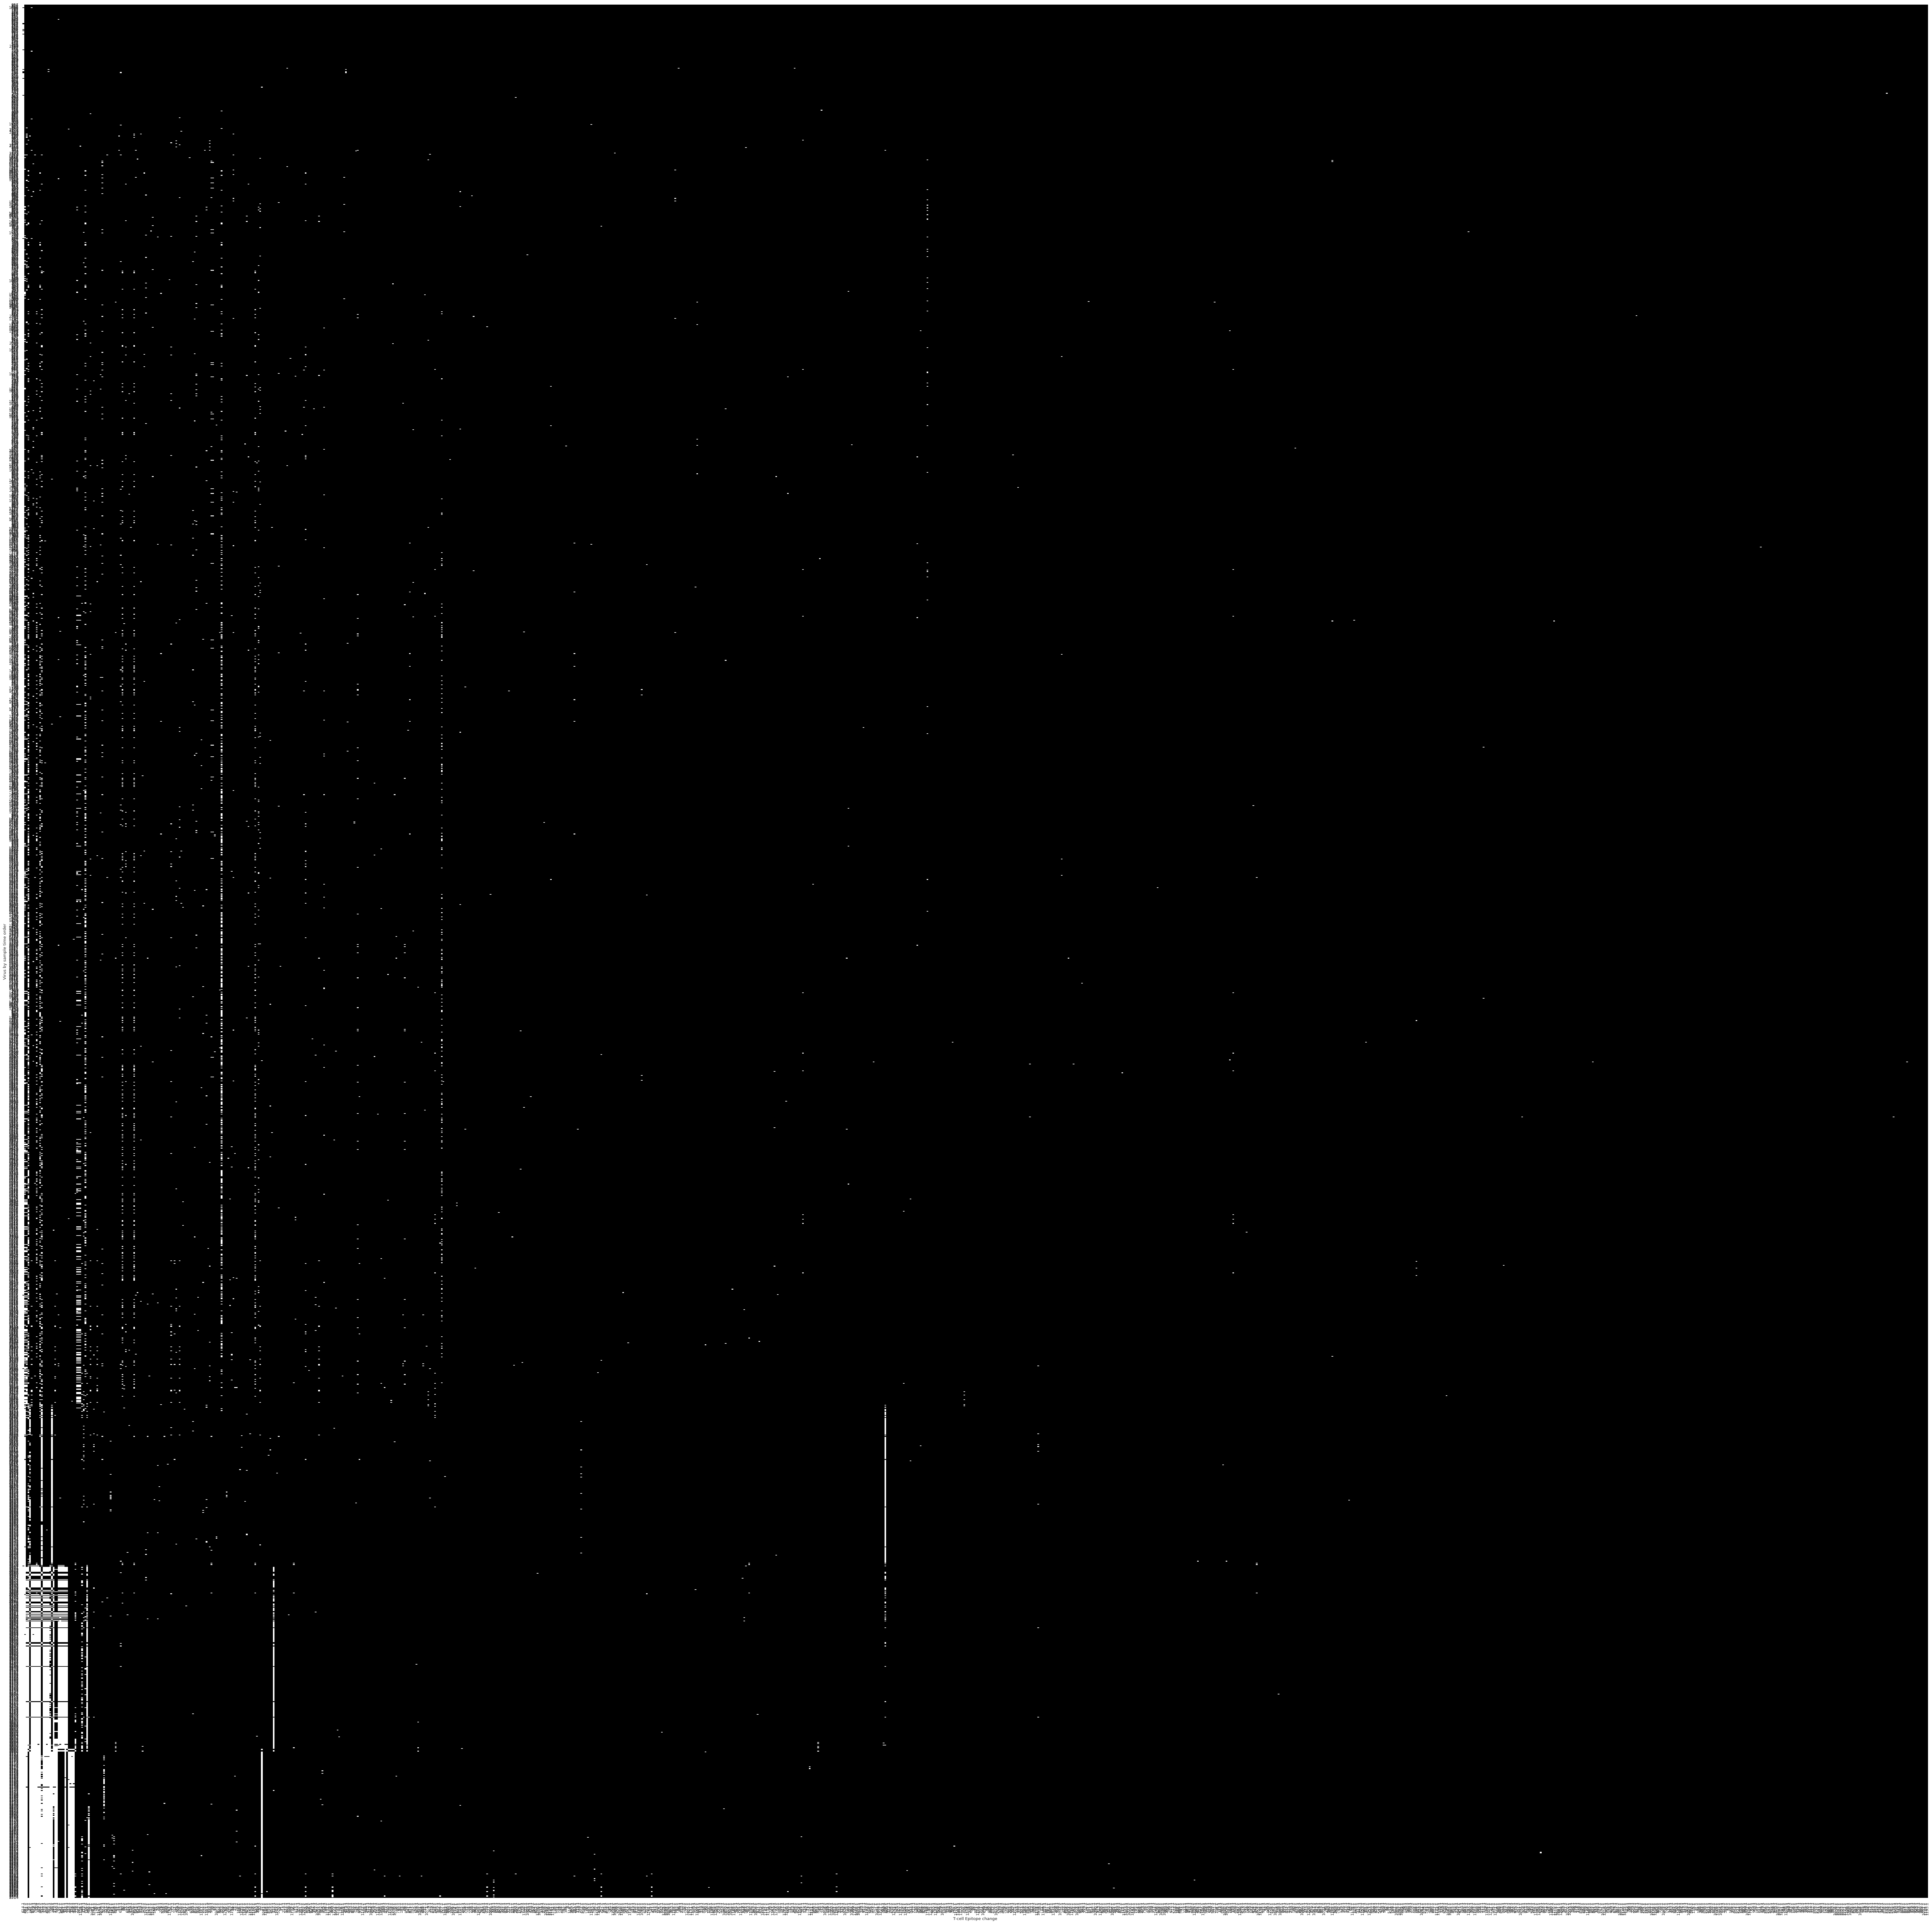

In [66]:
Tcell_data = pd.read_csv('tcell_2022-08-11.csv')

Tcell_data['Amino acid replacement'] = [re.sub('[^0-9]','', i) for i in Tcell_data['Amino acid replacement']]

Tcell_data = Tcell_data[Tcell_data["CD4 CD8"] == "CD8"]

Epitope_position = Tcell_data[['Gene','Amino acid replacement']]

Position_E = []

Gene = Epitope_position['Gene']

AA = Epitope_position['Amino acid replacement']
for x, y in zip(Gene, AA):
    if "S" in x :
        Position_E.append(f'{y}.1')
    elif "M" in x:
        Position_E.append(f'{y}.3')
    elif "N" in x:
        Position_E.append(f'{y}.9')
    elif "ORF3a" in x:
        Position_E.append(f'{y}.2')

Tcell_data['Epitope_position'] = Position_E

SAAP_profile = pd.read_csv('all_ORFs_SAAP.csv')

SAAP_profile = SAAP_profile.sort_values('Collection date')

filtered_AA = SAAP_profile.filter(Tcell_data.Epitope_position.drop_duplicates())

filtered_AA[filtered_AA > 0] = 1

print(filtered_AA.shape)

plt.figure(figsize=(80, 80))
ax = sns.heatmap(filtered_AA, cmap='gray', yticklabels = True, xticklabels = True, cbar=False, vmin=0, vmax=1)
plt.ylabel('Virus by sample time order')
plt.xlabel('T-cell Epitope change')
plt.savefig("T-cell_Epitope_change.pdf", format="pdf", bbox_inches="tight")
plt.show()



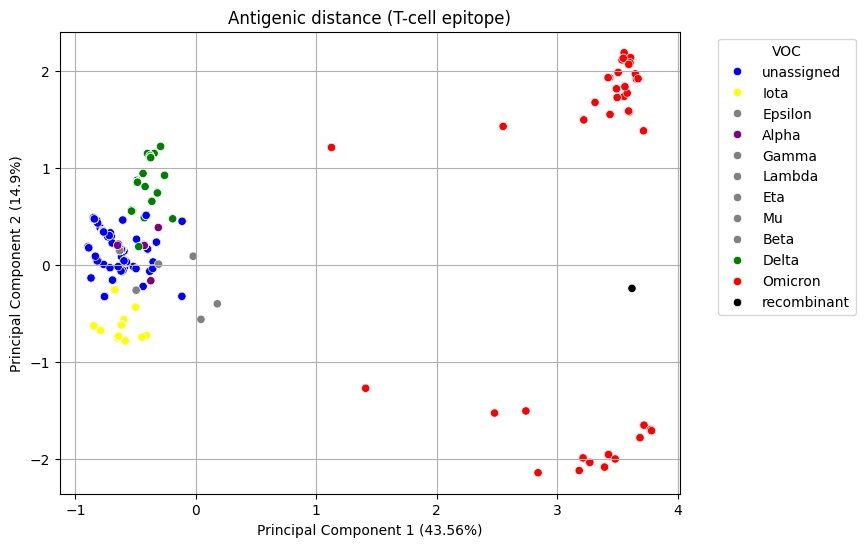

In [46]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Perform PCA
pca = PCA()
pca.fit(filtered_AA)

# Transform the data
pca_data = pca.transform(filtered_AA)

# Extract categories based on row index
categories = SAAP_profile["VOC"]
color_mapping = {'unassigned': 'blue', 'Iota': 'yellow', 'Alpha': 'purple',
                 'Delta':'green', 'Omicron':'red','Epsilon':'grey',
                 'Lambda':'grey', 'Gamma':'grey', 'Eta':'grey', 'Mu':'grey',
                 'Beta':'grey', 'recombinant':'black',
}

# Percentage of variance explained by each principal component
explained_variance_ratio = pca.explained_variance_ratio_

# Visualize PCA results along with the percentage of variance explained
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=categories.values.flatten(), palette=color_mapping)
plt.xlabel('Principal Component 1 ({}%)'.format(round(explained_variance_ratio[0] * 100, 2)))
plt.ylabel('Principal Component 2 ({}%)'.format(round(explained_variance_ratio[1] * 100, 2)))
plt.title('Antigenic distance (T-cell epitope)')
plt.grid(True)
legend = plt.legend(title='VOC')
legend.set_bbox_to_anchor((1.05, 1))
plt.savefig("CD8_antigen_dist_PCA.pdf", format="pdf", bbox_inches="tight")
plt.show()

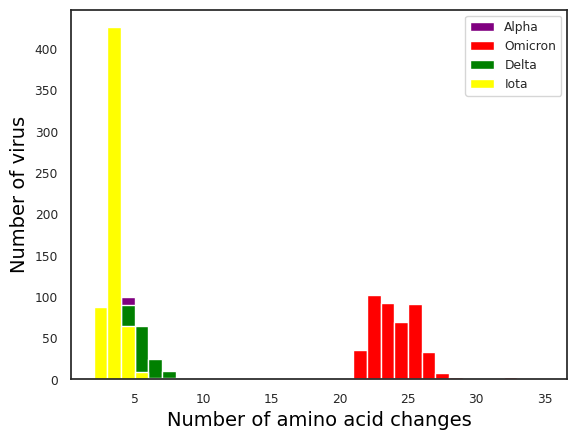

In [59]:
SAAP_profile.sort_values(by=["Collection date"])
#print(SAAP_profile)
filtered_AA.index = SAAP_profile["VOC"]
#print(aggregated_matrix)
Omicron_ab = filtered_AA[filtered_AA.index == 'Omicron']
Omicron_ab = Omicron_ab.loc[:, (Omicron_ab != 0).any()]
Delta_ab = filtered_AA[filtered_AA.index == 'Delta']
Delta_ab= Delta_ab.loc[:, (Delta_ab != 0).any()]
Iota_ab = filtered_AA[filtered_AA.index == 'Iota']
Iota_ab = Iota_ab.loc[:, (Iota_ab != 0).any()]
Alpha_ab = filtered_AA[filtered_AA.index == 'Alpha']
Alpha_ab = Alpha_ab.loc[:, (Alpha_ab != 0).any()]


Omicron_ab['sum'] = Omicron_ab.iloc[:, 2:].sum(axis=1)
Delta_ab['sum'] = Delta_ab.iloc[:, 2:].sum(axis=1)
Alpha_ab['sum'] = Alpha_ab.iloc[:, 2:].sum(axis=1)
Iota_ab['sum'] = Iota_ab.iloc[:, 2:].sum(axis=1)

# Specify common bin edges
bin_edges = range(min(min(Alpha_ab['sum']), min(Omicron_ab['sum']), min(Delta_ab['sum']), min(Iota_ab['sum'])),
                  max(max(Alpha_ab['sum']), max(Omicron_ab['sum']), max(Delta_ab['sum']), max(Iota_ab['sum'])) + 1)

plt.hist(Alpha_ab['sum'], color='purple', label='Alpha', bins=bin_edges, alpha=1)
plt.hist(Omicron_ab['sum'], color='red', label='Omicron', bins=bin_edges, alpha=1)
plt.hist(Delta_ab['sum'], color='green', label='Delta', bins=bin_edges, alpha=1)
plt.hist(Iota_ab['sum'], color='yellow', label='Iota', bins=bin_edges, alpha=1)

plt.ylabel("Number of virus",color="black",fontsize=14)
plt.xlabel("Number of amino acid changes",color="black",fontsize=14)
plt.legend()
plt.savefig("saap_TC_hist.pdf", format="pdf", bbox_inches="tight")
plt.show()

count_data = pd.DataFrame({
    'Counts': list(Alpha_ab['sum']) + list(Iota_ab['sum']) + list(Delta_ab['sum']) + list(Omicron_ab['sum']),
    'Group': ['Alpha'] * len(Alpha_ab['sum']) + ['Iota'] * len(Iota_ab['sum']) + ['Delta'] * len(Delta_ab['sum']) + ['Omicron'] * len(Omicron_ab['sum'])
})

<ipython-input-60-dd8ca544c20c>:5: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.7`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.

  sns.kdeplot(data=count_data, x='Counts', hue='Group', bw=0.7 ,fill=True, palette=['purple', 'yellow', 'green', 'red'], alpha=0.5, linewidth=0, ax=ax)


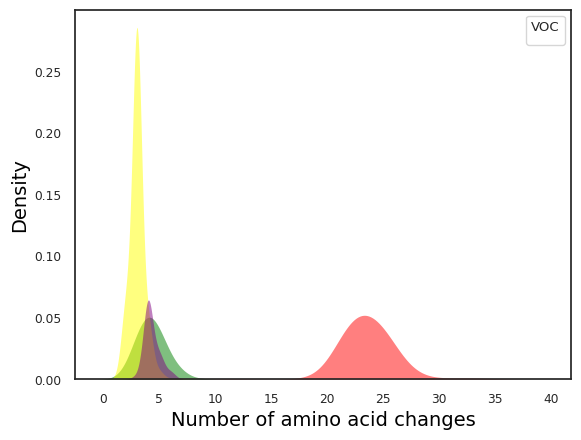

In [60]:
# Create a figure and axis objects
fig, ax = plt.subplots()

# Plot density plots
sns.kdeplot(data=count_data, x='Counts', hue='Group', bw=0.7 ,fill=True, palette=['purple', 'yellow', 'green', 'red'], alpha=0.5, linewidth=0, ax=ax)

# Set labels and legend
ax.set_xlabel("Number of amino acid changes", color="black", fontsize=14)
ax.set_ylabel("Density", color="black", fontsize=14)
ax.legend(title='VOC')

# Save or show the plot
plt.savefig("saap_TC_density_plots.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [67]:
SAAP_profile_sorted = SAAP_profile.sort_values(by=["Collection date"])

filtered_AA['sum'] = filtered_AA.iloc[:, 2:].sum(axis=1)
filtered_AA['Collection_date'] = SAAP_profile_sorted["Collection date"]
filtered_AA["VOC"] = SAAP_profile_sorted["VOC"]

voc = ['Omicron', 'Delta', 'Iota', 'Alpha']

virus_data = filtered_AA[filtered_AA.VOC.isin(voc)]
virus_data = virus_data[["Collection_date","VOC","sum"]]


print(virus_data)


     Collection_date      VOC  sum
1690      2020-12-03     Iota    3
1687      2020-12-04     Iota    3
602       2020-12-09     Iota    3
842       2020-12-16     Iota    4
845       2020-12-19     Iota    3
...              ...      ...  ...
2299      2022-10-18  Omicron   26
2301      2022-10-18  Omicron   32
2302      2022-10-18  Omicron   32
2315      2022-11-07  Omicron   27
2314      2022-11-14  Omicron   25

[1442 rows x 3 columns]


In [77]:
import statsmodels.api as sm

virus_data['Collection_date'] = pd.to_datetime(virus_data['Collection_date'])

# Encoding categorical variable 'VOC' into dummy variables
virus_data_dummy = pd.get_dummies(virus_data, columns=['VOC'], drop_first=False)

# Calculate the number of days elapsed since the earliest collection date
start_date = virus_data_dummy['Collection_date'].min()
virus_data_dummy['Days_elapsed'] = (virus_data_dummy['Collection_date'] - start_date).dt.days


# Creating interaction terms for each virus and time
virus_data_dummy['VOC_Alpha:time'] = virus_data_dummy['VOC_Alpha'] * virus_data_dummy['Days_elapsed']
virus_data_dummy['VOC_Iota:time'] = virus_data_dummy['VOC_Iota'] * virus_data_dummy['Days_elapsed']
virus_data_dummy['VOC_Delta:time'] = virus_data_dummy['VOC_Delta'] * virus_data_dummy['Days_elapsed']
virus_data_dummy['VOC_Omicron:time'] = virus_data_dummy['VOC_Omicron'] * virus_data_dummy['Days_elapsed']

# Define the independent variables X and the dependent variable y
X = virus_data_dummy[['VOC_Alpha', 'VOC_Iota', 'VOC_Delta', 'VOC_Omicron',
                      'VOC_Alpha:time', 'VOC_Iota:time', 'VOC_Delta:time', 'VOC_Omicron:time']]

y = virus_data_dummy['sum']

# Add a constant to the independent variables (OLS regression intercept)
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Print the summary of the regression results
print(model.summary())

print("\nTesting if coefficients of Alpha and Iota are equal:")
print("F-test p-value:", model.f_test("VOC_Alpha = VOC_Iota"))

print("\nTesting if coefficients of Alpha and Delta are equal:")
print("F-test p-value:", model.f_test("VOC_Alpha = VOC_Delta"))

print("\nTesting if coefficients of Alpha and Omicron are equal:")
print("F-test p-value:", model.f_test("VOC_Alpha = VOC_Omicron"))

print("\nTesting if coefficients of Delta and Iota are equal:")
print("F-test p-value:", model.f_test("VOC_Delta = VOC_Iota"))

print("\nTesting if coefficients of Delta and Omicron are equal:")
print("F-test p-value:", model.f_test("VOC_Delta = VOC_Omicron"))

print("\nTesting if coefficients of Iota and Omicron are equal:")
print("F-test p-value:", model.f_test("VOC_Iota = VOC_Omicron"))


                            OLS Regression Results                            
Dep. Variable:                    sum   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                 1.080e+04
Date:                Thu, 29 Feb 2024   Prob (F-statistic):               0.00
Time:                        23:50:07   Log-Likelihood:                -2363.7
No. Observations:                1442   AIC:                             4743.
Df Residuals:                    1434   BIC:                             4786.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                5.7639      0.133  

# Figure 2 C & D: VOC proportion of cases

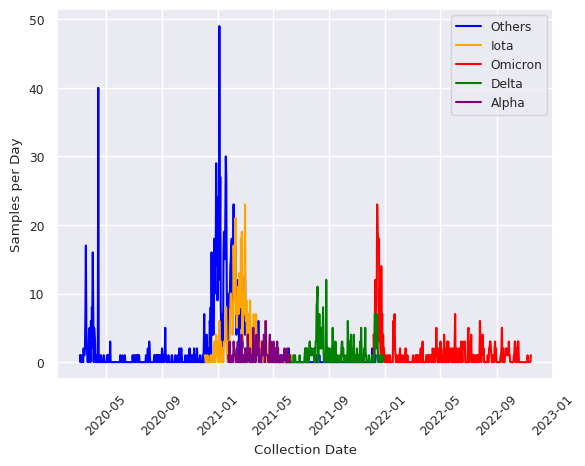

In [91]:
clade_for_plotting = []
for clade_who, clade_nextstrain in zip(nextclade['clade_who'], nextclade['clade_nextstrain']):
    if clade_who == 'unassigned':
        clade_for_plotting.append('Others')
    else:
        clade_for_plotting.append(clade_who)

nextclade['clades'] = clade_for_plotting

nextclade['Collection date'] = pd.to_datetime(nextclade['Collection date'])
clade_dict = {}
for clade in nextclade['clades'].unique():
    clade_data = nextclade.loc[nextclade['clades'] == clade,]
    clade_data = clade_data.set_index('Collection date')
    clade_data = clade_data.resample('D').size().fillna(0)
    clade_dict[clade] = (clade_data.index, clade_data.values)

clade_totals = {clade: sum(data[1]) for clade, data in clade_dict.items()}
sorted_clades = sorted(clade_totals, key=clade_totals.get, reverse=True)

# plot only the top 6 lineages with different colors
colors = ['blue', 'orange', 'red', 'green', 'purple']
fig, ax = plt.subplots()
lines = []
for i, clade in enumerate(sorted_clades[:5]):
    x, y = clade_dict[clade]
    color = f'C{i}'  # generate a different color for each lineage
    line, = ax.plot(x, y, label=clade, color=colors[i])
    lines.append(line)
# add axis labels and legend
ax.set_xlabel('Collection Date')
ax.set_ylabel('Samples per Day')
ax.legend()
plt.xticks(rotation = 45)
plt.savefig("Top5VOC.pdf", format="pdf", bbox_inches="tight")
# show the plot
plt.show()


In [92]:
import pandas as pd
import numpy as np


# Create an empty DataFrame
df = pd.DataFrame()

# Iterate over each clade
for clade in sorted_clades[:5]:
    # Get the clade data from the clade_dict
    x, y = clade_dict[clade]

    # Create a temporary DataFrame for the clade
    temp_df = pd.DataFrame({
        clade: y
    }, index=x)

    # Merge the temporary DataFrame with the main DataFrame
    df = pd.concat([df, temp_df], axis=1)

# Sort the DataFrame by the index (dates) column
df.sort_index(inplace=True)
# Replace NaN values with zeroes
df.fillna(0, inplace=True)
# Display the DataFrame
print(df)
bronx_clades = df


                 Others  Iota  Omicron  Delta  Alpha
Collection date                                     
2020-03-06          1.0   0.0      0.0    0.0    0.0
2020-03-07          0.0   0.0      0.0    0.0    0.0
2020-03-08          1.0   0.0      0.0    0.0    0.0
2020-03-09          0.0   0.0      0.0    0.0    0.0
2020-03-10          0.0   0.0      0.0    0.0    0.0
...                 ...   ...      ...    ...    ...
2022-11-10          0.0   0.0      0.0    0.0    0.0
2022-11-11          0.0   0.0      0.0    0.0    0.0
2022-11-12          0.0   0.0      0.0    0.0    0.0
2022-11-13          0.0   0.0      0.0    0.0    0.0
2022-11-14          0.0   0.0      1.0    0.0    0.0

[984 rows x 5 columns]


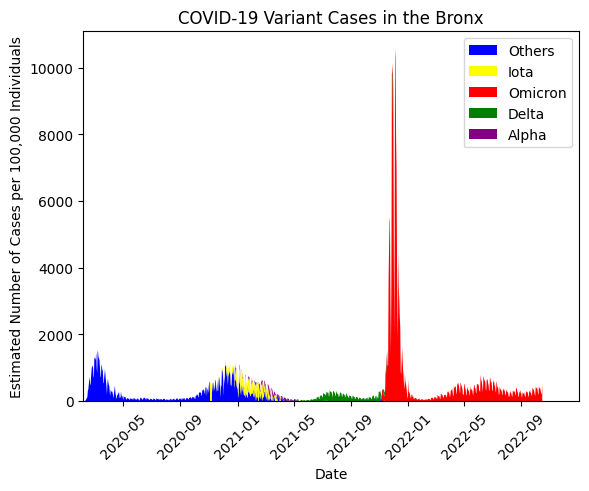

In [101]:
import matplotlib.pyplot as plt
import numpy as np
import datetime
sns.reset_orig()

# Extract the total case data
case_data = ts_case
variant_data = bronx_clades
variant_data.index = pd.to_datetime(variant_data.index)

# Calculate the row sums
row_sums = variant_data.sum(axis=1)
# Divide each value in the DataFrame by the corresponding row sum
normalized_data = variant_data.div(row_sums, axis=0).fillna(method='ffill', axis=0)

# Merge the dataframes based on a common time column
merged_data = pd.merge(case_data, normalized_data, left_index=True, right_index=True)

# Calculate the number of cases caused by each variant
cases_by_variant = merged_data[['Others',  'Iota',  'Omicron',  'Delta',  'Alpha']].multiply(merged_data['y'], axis=0)


colors = ['blue', 'yellow', 'red', 'green', 'purple']
# Plot the data
fig, ax = plt.subplots()
# Create a stacked area plot
ax.stackplot(cases_by_variant.index, cases_by_variant.values.T, labels=cases_by_variant.columns, colors=colors)

plt.xlabel('Date')
plt.ylabel('Estimated Number of Cases per 100,000 Individuals')
plt.title('COVID-19 Variant Cases in the Bronx')
plt.legend()
# Set x-axis limit to end on January 1st
end_date = datetime.datetime(2023, 2, 1)
plt.xlim(df.index[0], end_date)
plt.xticks(
    rotation=45,
    ticks=pd.date_range(start='2020-05', end='2023-01', freq='4M'),
    labels=pd.date_range(start='2020-05', end='2023-01', freq='4M').strftime('%Y-%m')
)
plt.savefig("Variant_proportions_bronx.pdf", format="pdf", bbox_inches="tight")

plt.show()




In [102]:
cases_by_variant.to_csv("Estimated_C19_VOC_cases.csv")

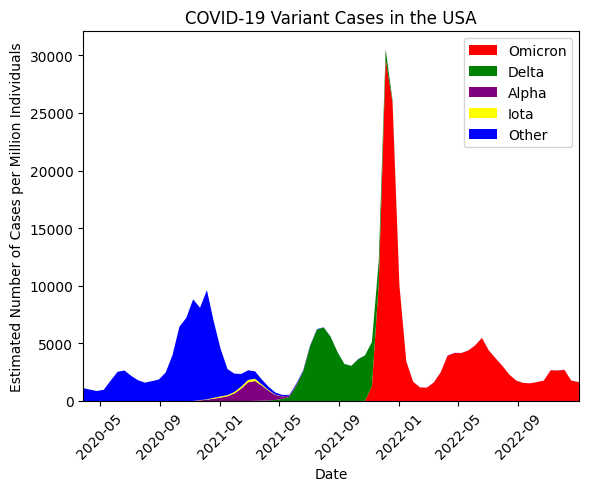

In [103]:
import json
import pandas as pd
import datetime
import matplotlib.pyplot as plt


# Load the JSON data
with open('perCountryDataCaseCounts.json') as json_file:
    data = json.load(json_file)

# Get the distribution data for the USA country
usa_distribution = None
for region in data['regions']:
    for distribution in region['distributions']:
        if distribution['country'] == 'USA':
            usa_distribution = distribution
            break

# Check if the USA distribution data is found
if usa_distribution is None:
    print("No distribution data found for the USA country.")
    exit()

# Initialize the lists for variant cases
omicron_cases = []
delta_cases = []
alpha_cases = []
iota_cases = []
other_cases = []
weeks = []

# Iterate over the distribution data
for distribution in usa_distribution['distribution']:
    week = distribution['week']
    weeks.append(week)

    cases = distribution['stand_estimated_cases']

    omicron_cases.append(
        cases['21K (Omicron)'] + cases['21L (Omicron)'] + cases['22A (Omicron)'] +
        cases['22B (Omicron)'] + cases['22C (Omicron)'] + cases['22D (Omicron)'] +
        cases['22E (Omicron)'] + cases['22F (Omicron)'] + cases['23A (Omicron)'] +
        cases['23B (Omicron)']
    )

    delta_cases.append(
        cases['21A (Delta)'] + cases['21I (Delta)'] + cases['21J (Delta)']
    )

    alpha_cases.append(cases['20I (Alpha, V1)'])
    iota_cases.append(cases['21F (Iota)'])

    other_cases.append(cases["20A.EU2"] +
        cases["20A/S:126A"] +
        cases["20A/S:439K"] +
        cases["20A/S:98F"] +
        cases["20B/S:732A"] +
        cases["20E (EU1)"] +
        cases["20H (Beta, V2)"] +
        cases["20J (Gamma, V3)"] +
        cases["21B (Kappa)"] +
        cases["21C (Epsilon)"] +
        cases["21D (Eta)"] +
        cases["21G (Lambda)"] +
        cases["21H (Mu)"] +
        cases["S:677H.Robin1"] +
        cases["S:677P.Pelican"] +
        cases["others"] +
        cases["recombinant"])

# Create a DataFrame for the variant cases
df = pd.DataFrame({
    'Omicron': omicron_cases,
    'Delta': delta_cases,
    'Alpha': alpha_cases,
    'Iota': iota_cases,
    'Other': other_cases
}, index=pd.DatetimeIndex(weeks))

colors = ['red', 'green', 'purple', 'yellow', 'blue']
# Plot the data
fig, ax = plt.subplots()
# Create a stacked area plot
ax.stackplot(df.index, df.values.T, labels=df.columns, colors=colors)

plt.xlabel('Date')
plt.ylabel('Estimated Number of Cases per Million Individuals')
plt.title('COVID-19 Variant Cases in the USA')
plt.legend()
# Set x-axis limit to end on January 1st
end_date = datetime.datetime(2023, 2, 1)
plt.xlim(df.index[0], end_date)
plt.xticks(
    rotation=45,
    ticks=pd.date_range(start='2020-05', end='2023-01', freq='4M'),
    labels=pd.date_range(start='2020-05', end='2023-01', freq='4M').strftime('%Y-%m')
)

plt.savefig("Variant_proportions_usa.pdf", format="pdf", bbox_inches="tight")

plt.show()
